http://www.gisdeveloper.co.kr/?p=2332

https://vverde.github.io/blob/interactivechoropleth.html

https://medium.com/@kribjer/spatiotemporal-timelapse-visualization-of-covid-19-with-python-f3e8e12693d1

https://cran.r-project.org/web/packages/forecastML/vignettes/grouped_forecast.html

https://www.kaggle.com/elenapetrova/time-series-analysis-and-forecasts-with-prophet

https://dacon.io/competitions/official/82407/talkboard/400442

In [2]:
# save the directory of the required files as "path"

path='/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/KB/'

Run this code in case matplotlib does not have Korean fonts installed. For google colab, run this cell and then restart runtime and re-run this cell for the Korean fonts to be installed in matplotlib.

In [1]:
# 한글폰트 사용 in colab

%matplotlib inline  

import matplotlib 
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm  

!apt-get update -qq
!apt-get install fonts-nanum* -qq

font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=font_path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
matplotlib.rcParams['axes.unicode_minus'] = False

NanumBarunGothic


Importing required modules

In [7]:
import pandas as pd
import numpy as np
import plotly
import datetime
import seaborn as sns
from matplotlib import cm
colors = cm.get_cmap('rainbow')

In [ ]:
import warnings
warnings.filterwarnings("ignore")


In [24]:
!pip install geopandas

     |████████████████████████████████| 994 kB 5.2 MB/s 
     |████████████████████████████████| 15.4 MB 81 kB/s 
     |████████████████████████████████| 6.6 MB 43.1 MB/s 


In [25]:
import json
import folium
from folium.plugins import TimeSliderChoropleth
from pandas.io.json import json_normalize

import os
import geopandas as gpd
from branca.colormap import linear
from shapely.geometry import Polygon
from branca.colormap import LinearColormap

In [8]:
data=pd.read_csv(path+'KB국민카드_금융빅데이터경진대회_데이터_raw2.csv')

Created a 'date' column as a Timestamp datatype to process time data.

In [9]:
data['date'] = data[['기준년도', '기준년월']].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
data['date']=pd.to_datetime(data['date'])



Here is a quick view of the dataset of interest. There are 311624 rows and 16 columns.


In [10]:
data

기준년도  기준년월  한글시도명   한글시군구명 법정동리명  ... 체크카드보유여부  회원수 매출건수 순위       date
0       2019     3    경기도  성남시 분당구   구미동  ...        1  112  125  3 2019-03-01
1       2019     3    경기도  성남시 분당구   구미동  ...        0    9    9  3 2019-03-01
2       2019     3    경기도  성남시 분당구   구미동  ...        1   49   56  3 2019-03-01
3       2019     3    경기도  성남시 분당구   구미동  ...        1   30   32  3 2019-03-01
4       2019     3    경기도  성남시 분당구   구미동  ...        0   27   31  3 2019-03-01
...      ...   ...    ...      ...   ...  ...      ...  ...  ... ..        ...
311620  2021     3  서울특별시      마포구   합정동  ...        0   17   22  5 2021-03-01
311621  2021     3  서울특별시      마포구   합정동  ...        1   42   49  5 2021-03-01
311622  2021     3  서울특별시      마포구   합정동  ...        1    3    3  5 2021-03-01
311623  2021     3  서울특별시      마포구   합정동  ...        0   17   20  5 2021-03-01
311624  2021     3  서울특별시      마포구   합정동  ...        1   14   16  5 2021-03-01

[311625 rows x 16 columns]

In [26]:
"""
'HangJeongDong_ver20210401.geojson' contains the necessary polygon shapes of 법정동, which uses 법정동코드 as the identifer. 
We can map the polygon shapes by 법정동 to our data by merging on 법정동. However, I found that 법정동 is sometimes unreliable as an identifer, 
and using 행정구역코드 is generally better. 

In our data 법정동코드 is the unique identifier.
However, the Geojson file 'HangJeongDong_ver20210401.geojson' is uses 행정구역코드 as the unique identifer. 
Fortunately, 서울행정구역분류_20210701.csv data contains the necessary 법정동코드 and 행정구역코드. 
We will use functions to merge by the common identifers, then calculate the mean of each column in the data when grouped by 행정구역(법정동)
"""

행정구역 = pd.read_csv(path+'서울_성남행정구역_20210701.csv')
행정구역 = 행정구역.apply(pd.to_numeric , errors='ignore')
행정구역['법정동리명'] = 행정구역['법정동']
행정구역['법정동코드'] = 행정구역['법정동코드'].astype(int)
행정구역['행정구역코드'] = 행정구역['행정구역코드'].astype(int)

data_법정동= data.merge(행정구역[['법정동리명','행정구역코드']], on='법정동리명') 

dong_shape = gpd.read_file(path+'HangJeongDong_ver20210401.geojson')
dong_shape['행정구역코드'] = dong_shape['adm_cd']
dong_shape['행정구역코드'] = dong_shape['행정구역코드'].astype(int)
dong_polygon = data_법정동.merge(dong_shape[['geometry','행정구역코드']], on='행정구역코드')

In [27]:
행정구역

시도      시군구  행정구역명 행정동(행정기관명)  ... 법정동 관할지역            행정동 영문명칭   비고  법정동리명
0    서울특별시    서울특별시  서울특별시      서울특별시  ...      NaN               Seoul  NaN  서울특별시
1    서울특별시      종로구    종로구        종로구  ...      NaN           Jongno-gu  NaN    종로구
2    서울특별시      종로구  청운효자동      청운효자동  ...      NaN  Cheongunhyoja-dong  NaN    청운동
3    서울특별시      종로구  청운효자동      청운효자동  ...      NaN  Cheongunhyoja-dong  NaN    신교동
4    서울특별시      종로구  청운효자동      청운효자동  ...      NaN  Cheongunhyoja-dong  NaN    궁정동
..     ...      ...    ...        ...  ...      ...                 ...  ...    ...
792    경기도  성남시 분당구    구미동        구미동  ...     분할연계           Gumi-dong  NaN    구미동
793    경기도  성남시 분당구    운중동        운중동  ...      NaN         Unjung-dong  NaN    운중동
794    경기도  성남시 분당구    운중동        운중동  ...      NaN         Unjung-dong  NaN    대장동
795    경기도  성남시 분당구    운중동        운중동  ...      NaN         Unjung-dong  NaN    석운동
796    경기도  성남시 분당구    운중동        운중동  ...      NaN         Unjung-dong  NaN   하산운동

[797 rows x 13 columns]

In [28]:
def mean_groupby_dong(path, data): 
  """
Requirements: 
1. '서울행정구역분류_20210701.csv'
2. preprocessed data

Input: directory as path, preprocessed data
Output: dongmean
  """
  ## c= data.merge(행정구역[['법정동코드','행정구역코드','행정동(행정기관명)']].drop_duplicates(subset='법정동코드', keep='first'), on='법정동코드')
  행정구역 = pd.read_csv(path+'서울_성남행정구역_20210701.csv')
  행정구역 = 행정구역.apply(pd.to_numeric , errors='ignore')
  행정구역['법정동리명'] = 행정구역['법정동']
  행정구역['행정구역코드'] = 행정구역['행정구역코드'].astype(int)
  map_data= data.merge(행정구역[['법정동리명','행정구역코드']], on='법정동리명') 
  dongmean = map_data.groupby(['기준년월', 'date' ,'행정구역코드']).mean().reset_index() # group by location and time and make mean data : dongmean
  dongmean['행정구역코드']=dongmean['행정구역코드'].astype(int)
  return dongmean

def sum_groupby_dong(path, data): 
  """
Requirements: 
1. '서울행정구역분류_20210701.csv'
2. preprocessed data

Input: directory as path, preprocessed data
Output: dongmean
  """
  ## c= data.merge(행정구역[['법정동코드','행정구역코드','행정동(행정기관명)']].drop_duplicates(subset='법정동코드', keep='first'), on='법정동코드')
  행정구역 = pd.read_csv(path+'서울_성남행정구역_20210701.csv')
  행정구역 = 행정구역.apply(pd.to_numeric , errors='ignore')
  행정구역['법정동리명'] = 행정구역['법정동']
  행정구역['행정구역코드'] = 행정구역['행정구역코드'].astype(int)
  map_data= data.merge(행정구역[['법정동리명','행정구역코드']], on='법정동리명')
  dongsum = map_data.groupby(['기준년월', 'date' ,'행정구역코드']).sum().reset_index() # group by location and time and make mean data : dongmean
  dongsum['행정구역코드']=dongsum['행정구역코드'].astype(int)
  return dongsum


def map_data_preprocessing(path, data_stat):
  """
Requirements: 
1. 'HangJeongDong_ver20210401.geojson'
2. dong_polygon, or the data merged with the polygon shapes.

Input: directory as path, dongmean
Output: 행정구역_gdf
# 
Use geopandas to load a dataset containing the dong_shape

  'HangJeongDong_ver20210401.geojson' contains the necessary polygon shapes of 법정동, which uses 법정동코드 as the identifer. 
  We can map the polygon shapes by 법정동 to our data by merging on 법정동. However, I found that 법정동 is sometimes unreliable as an identifer, 
  and using 행정구역코드 is generally better. 

  In our data 법정동코드 is the unique identifier.
  However, the Geojson file 'HangJeongDong_ver20210401.geojson' is uses 행정구역코드 as the unique identifer. 
  Fortunately, 서울행정구역분류_20210701.csv data contains the necessary 법정동코드 and 행정구역코드. 
  We will use functions to merge by the common identifers, then calculate the mean of each column in the data when grouped by 행정구역(법정동)

  """


  # merge on 행정구역
  
  # use geopandas to make geopandas df
  dong_shape = gpd.read_file(path+'HangJeongDong_ver20210401.geojson')
  dong_shape['행정구역코드'] = dong_shape['adm_cd']
  dong_shape['행정구역코드'] = dong_shape['행정구역코드'].astype(int)

  #polygon shapes merged on data
  dong_polygon = data_stat.merge(dong_shape[['geometry','행정구역코드']], on='행정구역코드')

  # Take the polygons of the merged data and make into GeoDataFrame. The 행정구역_gdf index matches that of dong_polygon
  행정구역_df = dong_polygon[['geometry']]
  행정구역_gdf = gpd.GeoDataFrame(행정구역_df)
  행정구역_gdf = 행정구역_gdf.drop_duplicates().reset_index() # 행정구역_gdf
  return 행정구역_gdf, dong_polygon

In [29]:
dongmean = mean_groupby_dong(path, data)
dongsum = sum_groupby_dong(path, data)

행정구역_gdf, dongmean_polygon = map_data_preprocessing(path, dongmean)
행정구역_gdf, dongsum_polygon = map_data_preprocessing(path, dongsum)

Looking at histograms of the data, the distributions of 회원수, 매출건수 and 순위 are all highly skewed. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1ec84469d0>,
      dtype=object)

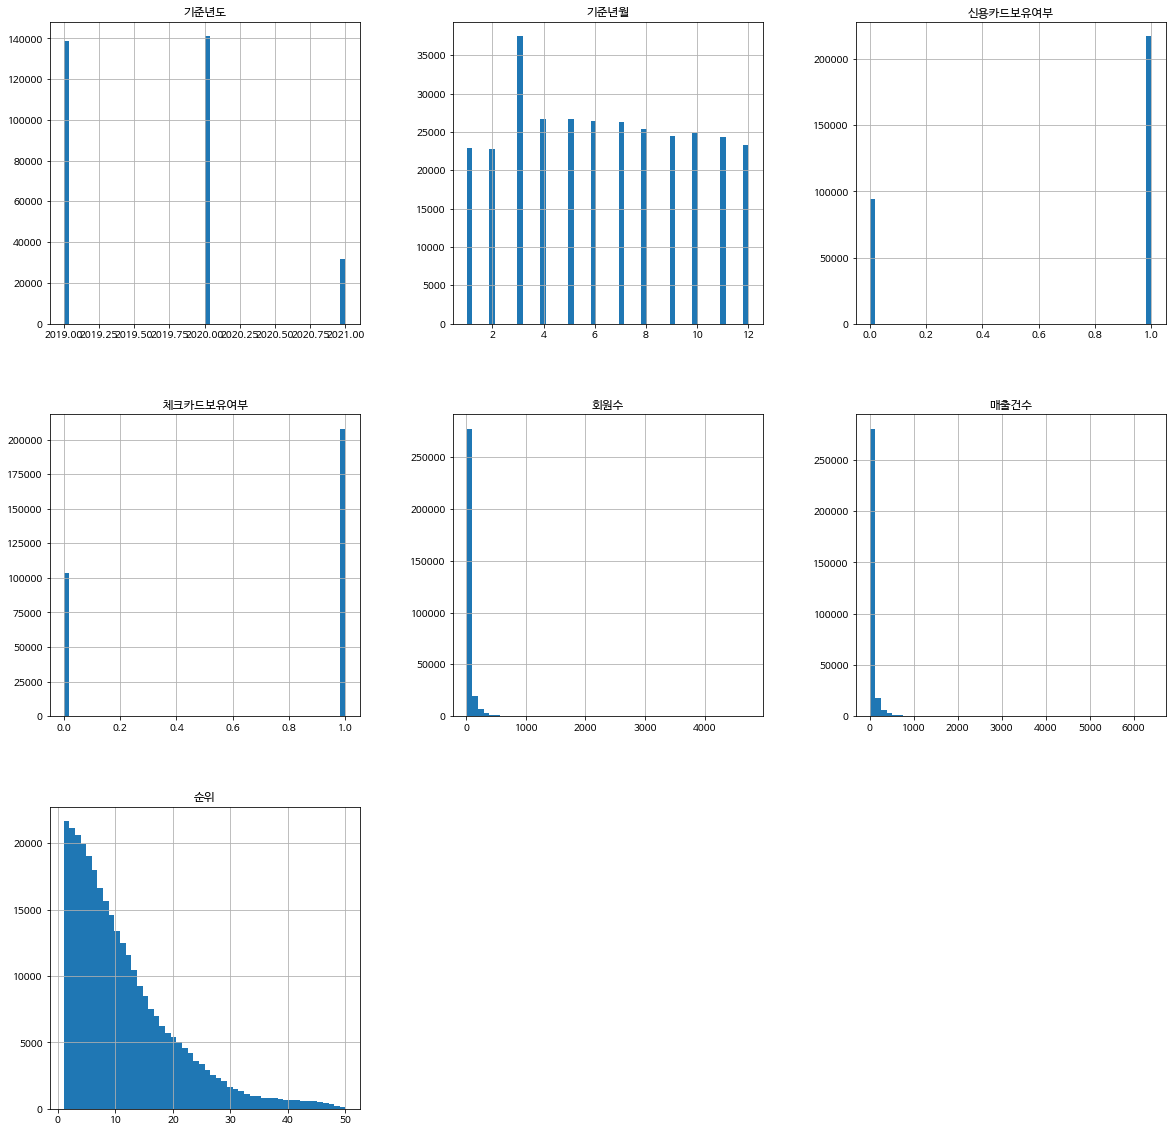

In [ ]:
data.hist(figsize=(20,20), bins =50)

Since 매출건수 is perhaps the outcome of most interest, we will focus on this attribute. 회원수 and 매출건수 are highly correlated anyways, as to be shown in a scatterplot and correlation matrix.

For 매출건수, Box-cox transformation or log-transformation seems sufficient in making the data less skewed. 

-0.1626131145181734


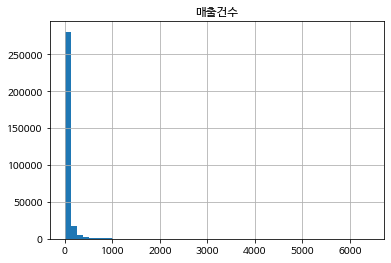

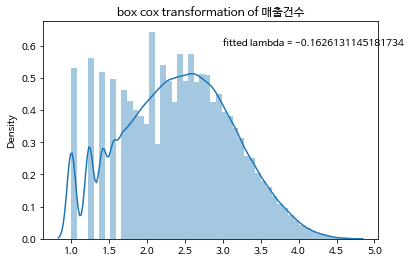

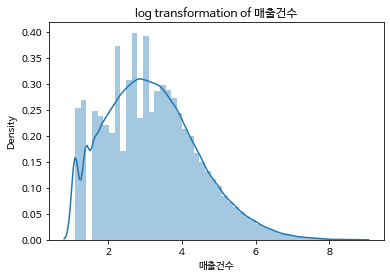

In [ ]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

plt.figure()
plt.title('매출건수')
data['매출건수'].hist(bins=50)

y,train_fitted_lambda= boxcox(data['매출건수'],lmbda=None)

plt.figure()
plt.title('box cox transformation of 매출건수')
plt.text(3, 0.6, "fitted lambda = {}".format(train_fitted_lambda))
sns.distplot(y)
print(train_fitted_lambda)

plt.figure()
plt.title('log transformation of 매출건수')
sns.distplot(np.log(data['매출건수']))

In [ ]:
data['log(매출건수)']=np.log(data['매출건수'])

count    311625.000000
mean         62.503586
std         168.925111
min           3.000000
25%          10.000000
50%          22.000000
75%          54.000000
max        6403.000000
Name: 매출건수, dtype: float64

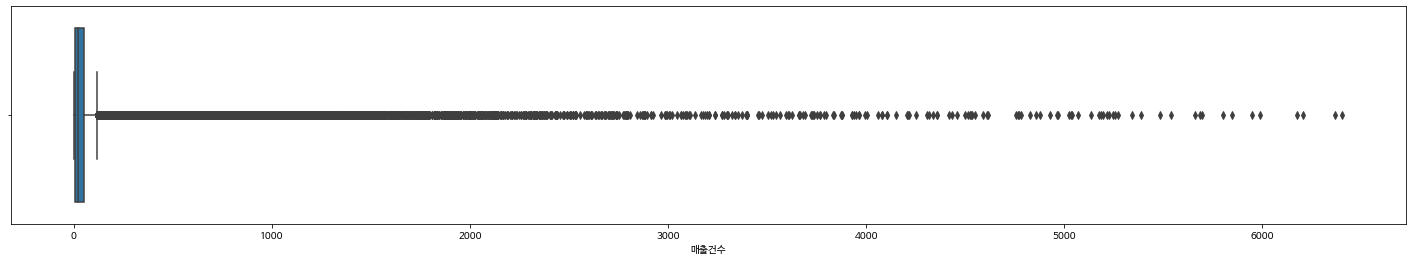

In [ ]:
plt.figure(figsize=(25,4))
sns.boxplot(data['매출건수'])
data['매출건수'].describe()

A box plot of the log transformed data showed that the distribution is less skewed. 

count    311625.000000
mean          3.190999
std           1.249865
min           1.098612
25%           2.302585
50%           3.091042
75%           3.988984
max           8.764522
Name: log(매출건수), dtype: float64

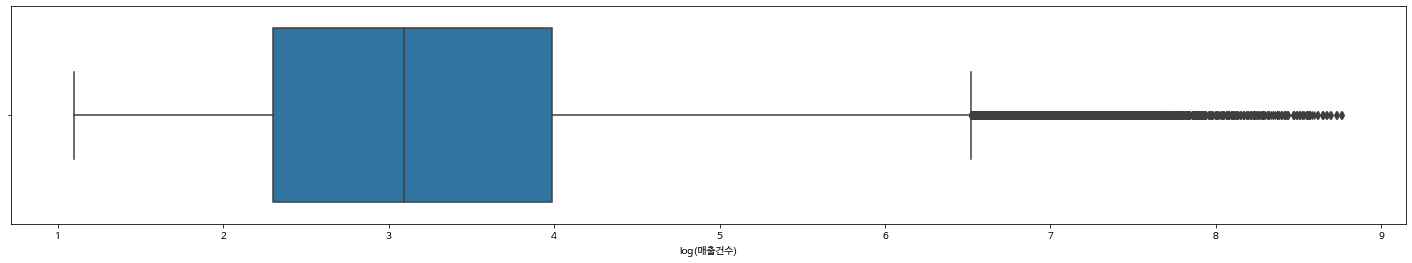

In [ ]:
plt.figure(figsize=(25,4))
sns.boxplot(data['log(매출건수)'])
data['log(매출건수)'].describe()

As mentioned before, a scatterplot of 회원수 and 매출건수 show that these two attributes are highly correlated. This makes sense larger membership size of a resteraunt usually means larger sales for that resteraunt. 

Text(0, 6000, 'pearson r =0.985848569690065')

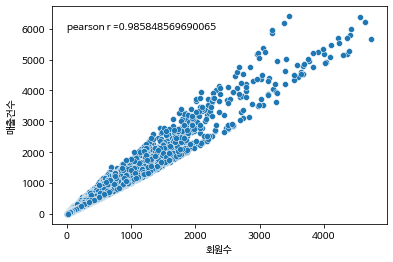

In [ ]:
from scipy import stats

sns.scatterplot(data['회원수'], data['매출건수'])
pearsonr = stats.pearsonr(data['회원수'], data['매출건수'])[0]
plt.text(x=0, y=6000, s="pearson r ={0}".format(pearsonr))


Samples with higher 매출건수 were placed in higher ranks.

However, a sample who placed higher in 순위 does not necessarily mean that sales volume 매출건수 was higher. The minimum 매출건수 for a sample 순위 ranked 1 is only 3. The same logic applies to 회원수. 

This means that 순위 and 


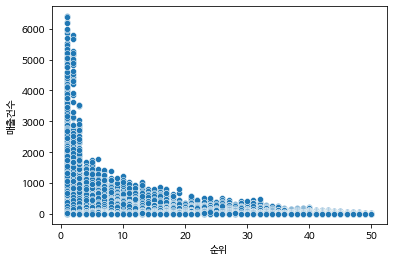

In [ ]:
sns.scatterplot(data['순위'], data['매출건수'])

# Categorical Variables

한글시도명 ,한글시군구명, 법정동리명 are location-based data, so a spacial map visualization could be helpful in comparing sales of different locations. Since time is another axis to be considered, visualizing the sales map by time can be helpful as well.

The most common location in the data is 강남구 역삼동.

마케팅업종중분류명,마케팅업종세분류명, 마케팅업종세세분류명, 성별구분, 연령대 are the characteristics of the particular row that represents each store. 


The most common cuisine type (마케팅업종세분류명) in the data is 국/탕/백반류, and the most common detailed cuisine type (마케팅업종세세분류명)  is 일반한식/백반. 

The data is fairly even across 성별 and 연령대. 

In [15]:
cat_features=['한글시도명','한글시군구명', '법정동리명', '마케팅업종중분류명','마케팅업종세분류명', '마케팅업종세세분류명', '성별구분','연령대', '신용카드보유여부',	'체크카드보유여부']

for col in cat_features: 
    try:      
        print("---- %s ---" % col)
        print(data[col].value_counts(dropna=False))
    except ValueError:
        print('This column can not be represented. Check datatype')

---- 한글시도명 ---
서울특별시    231112
경기도       80513
Name: 한글시도명, dtype: int64
---- 한글시군구명 ---
강남구        142295
마포구         88817
성남시 분당구     80513
Name: 한글시군구명, dtype: int64
---- 법정동리명 ---
역삼동    33617
논현동    22492
대치동    20920
삼성동    18007
서교동    17021
야탑동    15929
신사동    15885
정자동    14770
서현동    14073
삼평동    10693
수내동    10378
망원동    10147
공덕동    10011
상암동     9673
구미동     8855
도곡동     8842
동교동     8260
도화동     7841
청담동     7514
합정동     6383
개포동     6183
금곡동     5815
성산동     5459
일원동     5158
연남동     4057
수서동     3677
용강동     3629
상수동     3385
아현동     2951
Name: 법정동리명, dtype: int64
---- 마케팅업종중분류명 ---
한식    237227
일식     51573
양식     22825
Name: 마케팅업종중분류명, dtype: int64
---- 마케팅업종세분류명 ---
국/탕/백반류    85649
해산물        76439
돼지고기       56551
면요리        29451
소고기        27888
종합양식       18299
닭고기        11702
기타고기        3880
밥요리         1766
Name: 마케팅업종세분류명, dtype: int64
---- 마케팅업종세세분류명 ---
일반한식/백반        21678
삼겹살/구이전문점      18935
일식전문점          18478
종합양식           17321
국수/칼국수전문점      166

월 매출건수가 100 이하인 점들이 대다수 였다. (n=269921)

Since the data is highly skewed for 매출건수, it could be better to stratify the data into different levels of 매출건수. Sales less than 100 were the most abundant, so this was saved as the a seperate dataframe. The same goes for levels 100 to 500, 500 to 2000, and over 2000. The statistics and seperate box plots of the dataframes at different levels are shown in the following.

Count of sales less than 100 was 269921, which is the majority of the data.



In [ ]:
df_under100 = data[data['매출건수']<100]
df_over100_under500 = data[(data['매출건수']>=100) & (data['매출건수']<500)]
df_over500_under2000 = data[(data['매출건수']>=500) & (data['매출건수']<2000)]
df_over2000 = data[data['매출건수']>=2000]


 ---매출건수 >100--- 
 count    269921.000000
mean         25.807736
std          22.736552
min           3.000000
25%           8.000000
50%          18.000000
75%          36.000000
max          99.000000
Name: 매출건수, dtype: float64

 ---100 <= 매출건수 < 500--- 
 count    36553.000000
mean       199.017947
std         95.540804
min        100.000000
25%        125.000000
50%        165.000000
75%        245.000000
max        499.000000
Name: 매출건수, dtype: float64

 ---500 <= 매출건수 < 2000--- 
 count    4750.000000
mean      849.848632
std       347.161460
min       500.000000
25%       589.000000
50%       720.000000
75%      1001.000000
max      1999.000000
Name: 매출건수, dtype: float64

 ---매출건수 >=2000--- 
 count     401.000000
mean     2992.882793
std      1017.558143
min      2006.000000
25%      2213.000000
50%      2613.000000
75%      3506.000000
max      6403.000000
Name: 매출건수, dtype: float64

 ---매출건수 Total--- 
 count    311625.000000
mean         62.503586
std         168.925111
min    

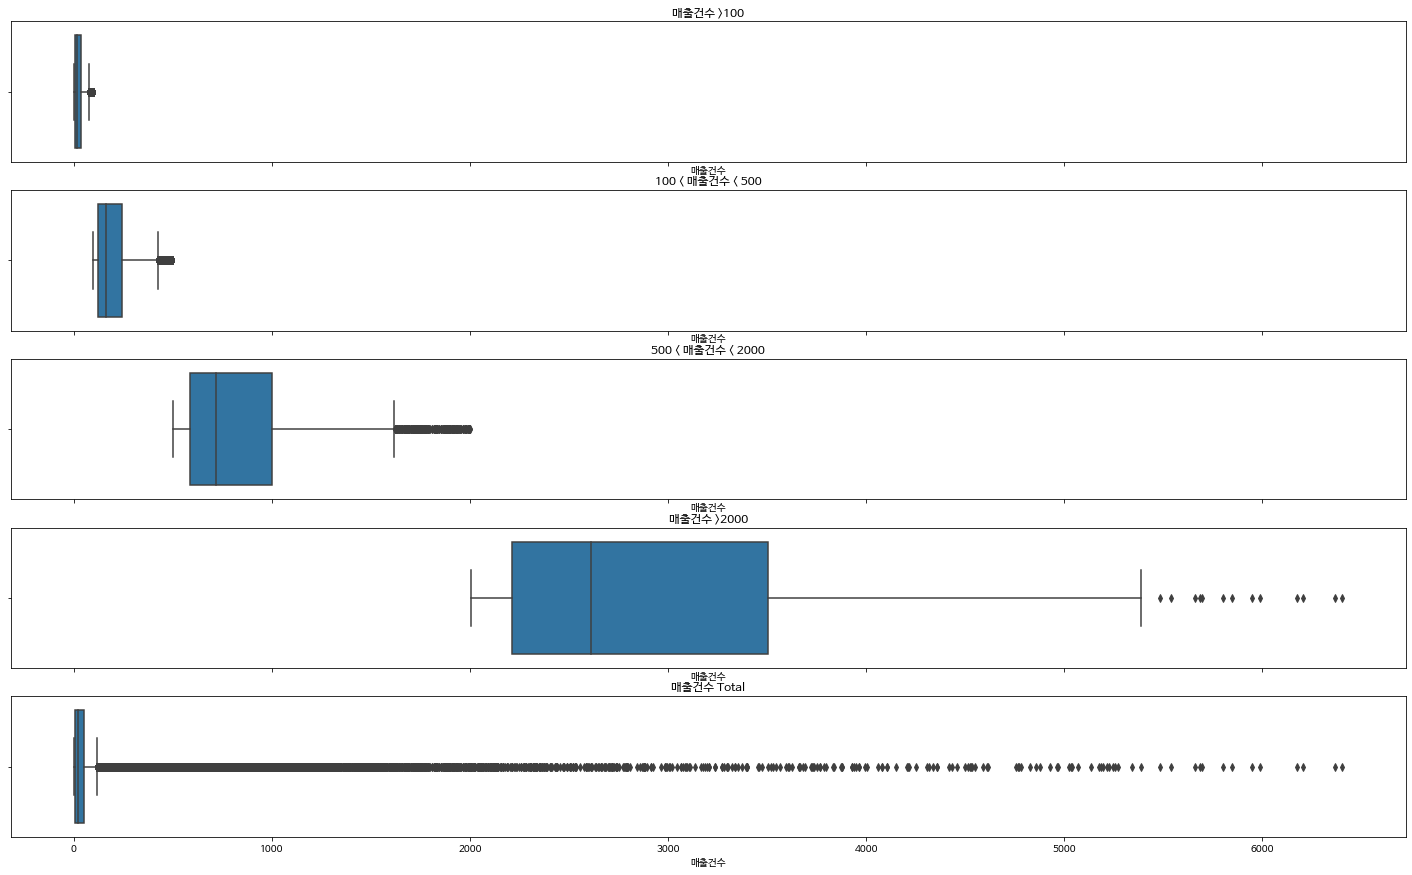

In [ ]:
f, axes = plt.subplots(5, 1, figsize=(25,15), sharex=True)
ax1=sns.boxplot(df_under100['매출건수'], ax=axes[0])
ax2=sns.boxplot(df_over100_under500['매출건수'], ax=axes[1])
ax3=sns.boxplot(df_over500_under2000['매출건수'], ax=axes[2])
ax4=sns.boxplot(df_over2000['매출건수'], ax=axes[3])
ax5=sns.boxplot(data['매출건수'], ax=axes[4])


ax1.title.set_text('매출건수 >100')
ax2.title.set_text('100 < 매출건수 < 500')
ax3.title.set_text('500 < 매출건수 < 2000')
ax4.title.set_text('매출건수 >2000')
ax5.title.set_text('매출건수 Total')

print('\n ---매출건수 >100--- \n', df_under100['매출건수'].describe())
print('\n ---100 <= 매출건수 < 500--- \n', df_over100_under500['매출건수'].describe())
print('\n ---500 <= 매출건수 < 2000--- \n', df_over500_under2000['매출건수'].describe())
print('\n ---매출건수 >=2000--- \n', df_over2000['매출건수'].describe())
print('\n ---매출건수 Total--- \n', data['매출건수'].describe())

# Correlation Plots 상관계수 분석

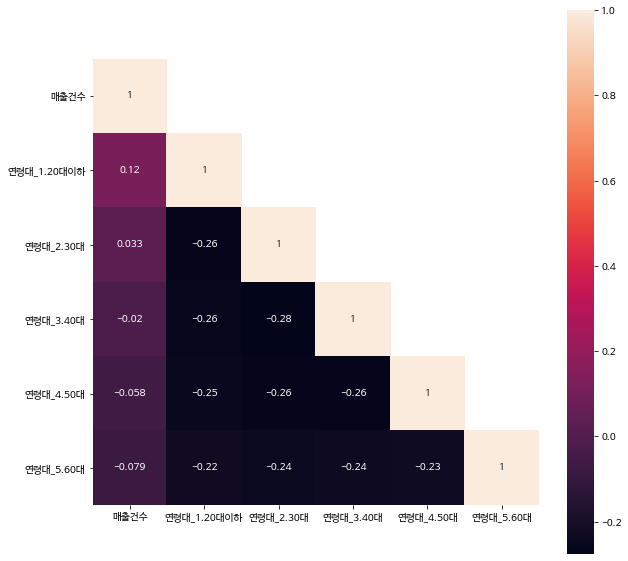

In [ ]:
df1 = data[['연령대','매출건수']]
df_cat = pd.get_dummies(df1)
cor_mat = df_cat.corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)]=False
fig = plt.gcf()
fig.set_size_inches(10,10)
sns.heatmap(data = cor_mat, mask = mask, square = True, annot = True, cbar = True);

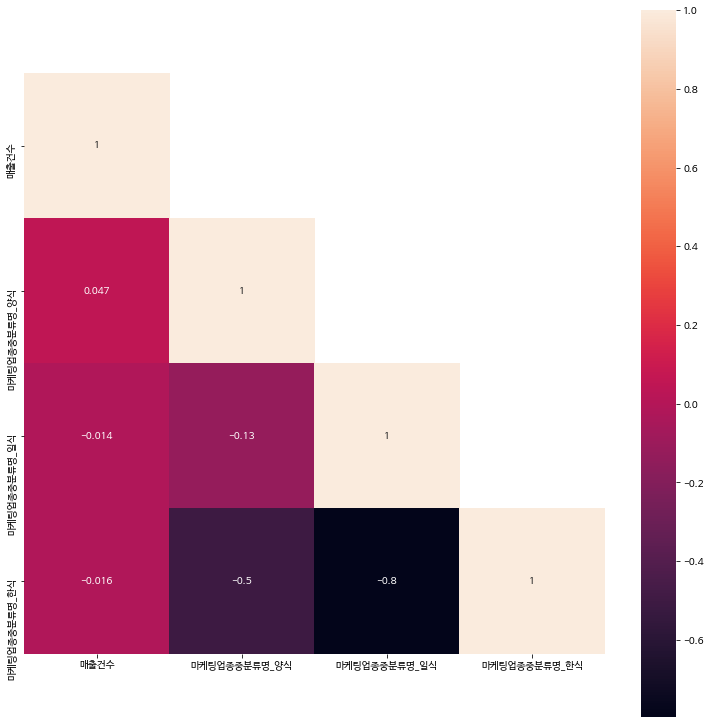

In [ ]:
df1 = data[['마케팅업종중분류명','매출건수']]
df_cat = pd.get_dummies(df1)
cor_mat = df_cat.corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)]=False
fig = plt.gcf()
fig.set_size_inches(13,13)
sns.heatmap(data = cor_mat, mask = mask, square = True, annot = True, cbar = True);

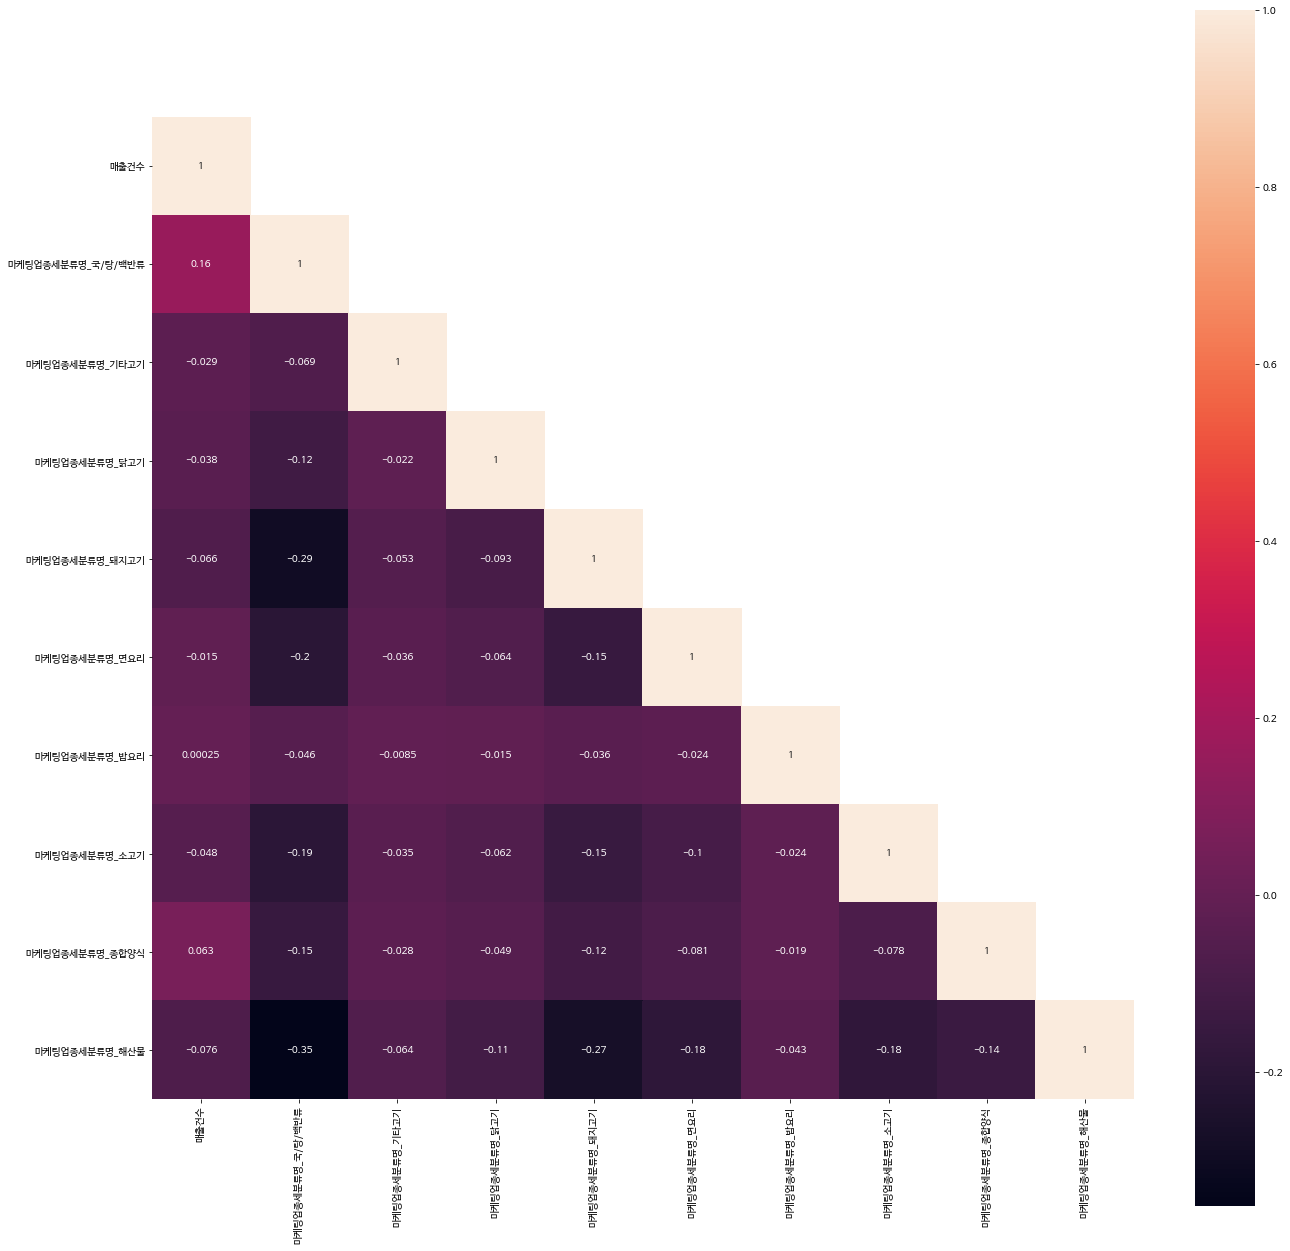

In [ ]:
df1 = data[['마케팅업종세분류명','매출건수']]
df_cat = pd.get_dummies(df1)
cor_mat = df_cat.corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)]=False
fig = plt.gcf()
fig.set_size_inches(22,22)
sns.heatmap(data = cor_mat, mask = mask, square = True, annot = True, cbar = True);

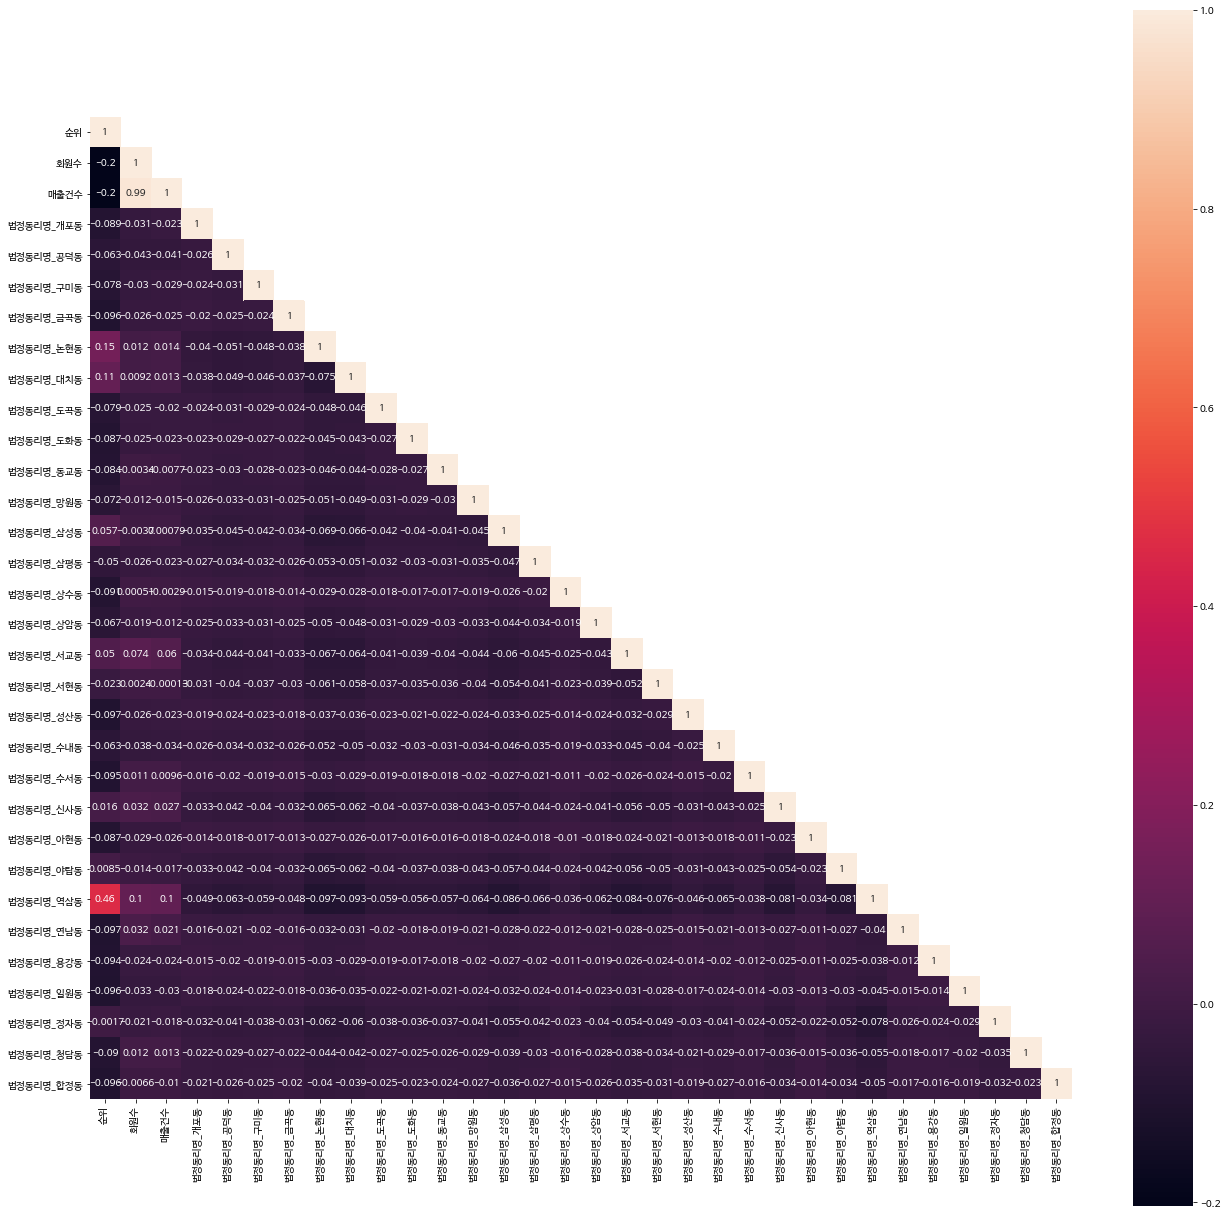

In [ ]:
df1 = data[['법정동리명','순위','회원수','매출건수']]
df_cat = pd.get_dummies(df1)
cor_mat = df_cat.corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)]=False
fig = plt.gcf()
fig.set_size_inches(22,22)
sns.heatmap(data = cor_mat, mask = mask, square = True, annot = True, cbar = True);

# Dot Plot by category

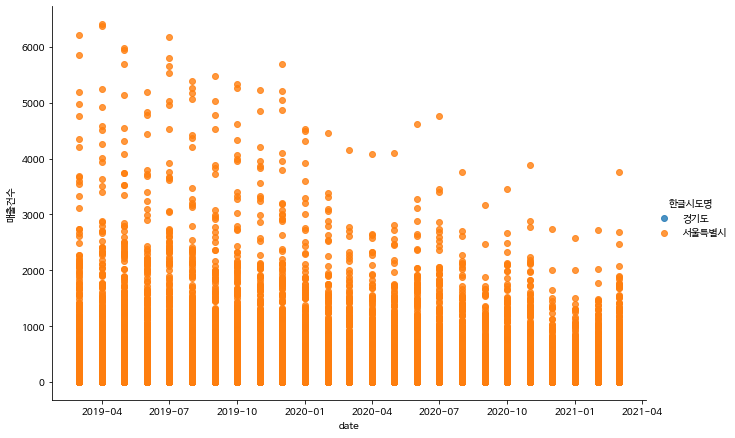

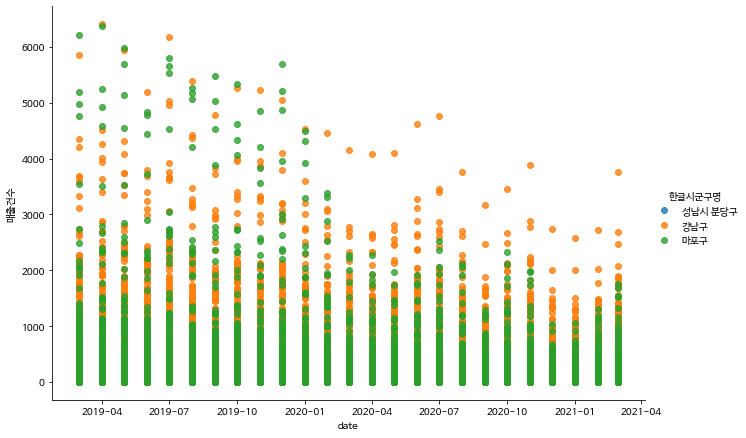

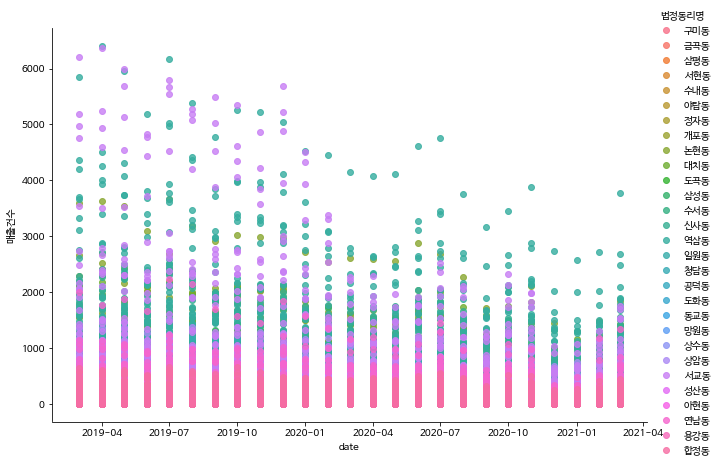

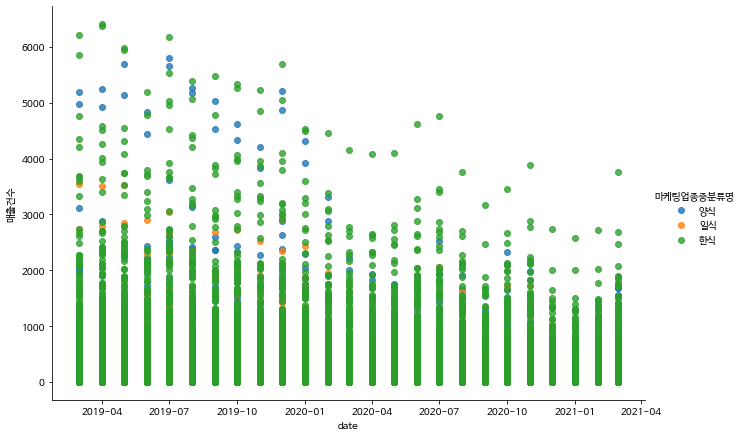

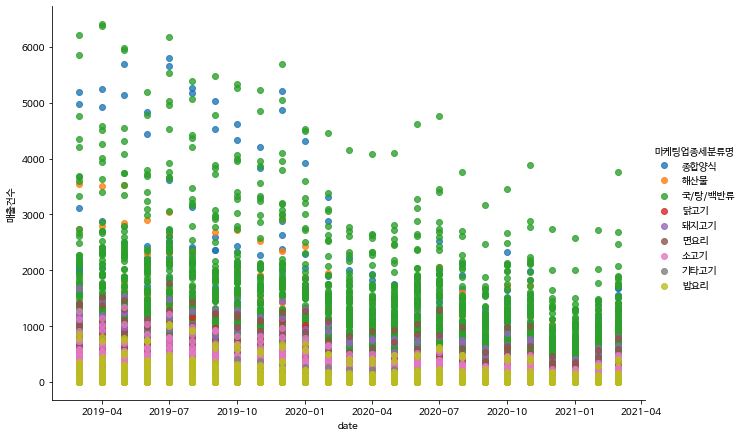

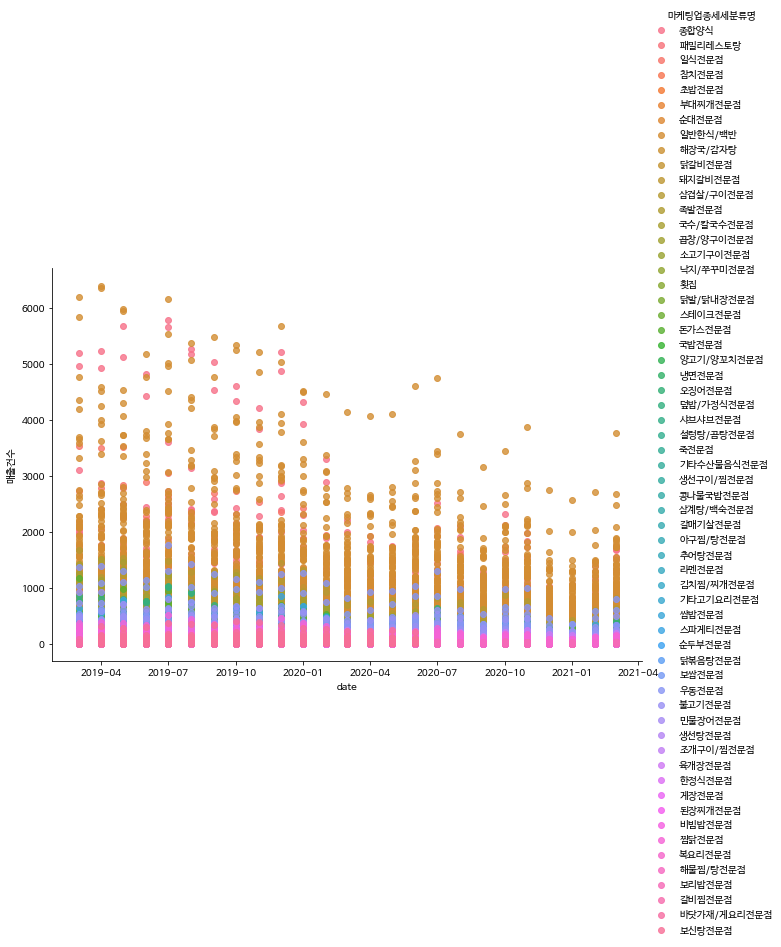

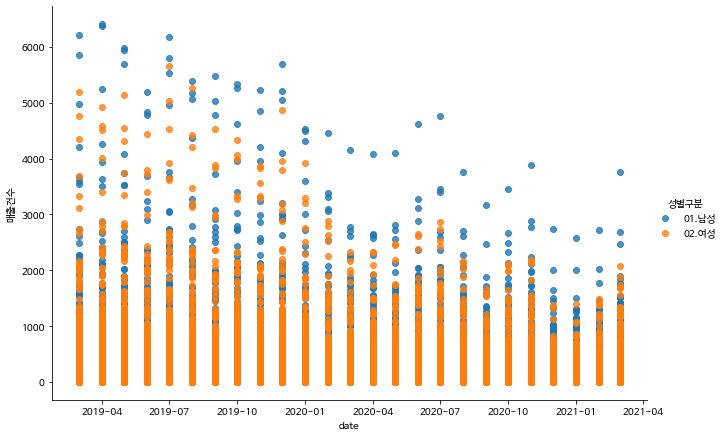

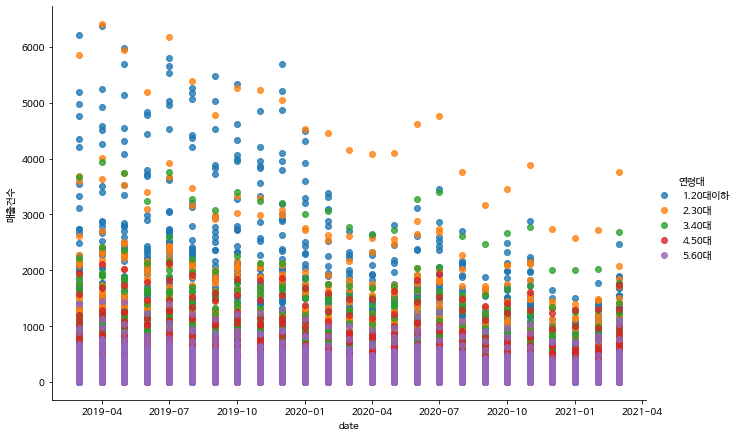

In [ ]:
for i, name in enumerate(cat_features):
  g = sns.lmplot(x='date', y='매출건수', data=data, hue=name, fit_reg=False, height=6, aspect=1.5)

# 시간별 총 매출건수

마케팅업종세분류명, 마케팅업종세세분류명, 법정동리명, 연령대 별로 총 매출건수 들을 게산하여, 시간별로 그래프에 나타냈습니다. 항목들이 많은 경우, 색깔별로 나타내기 어려워, 이를 시각화하는데 어려움을 느낄수 있습니다. 그런점을 감안해, 월별 % 변화를 환산하여 heatmap으로 나타내는 다른 방법으로 시각화하는것이 좋을듯 합니다.



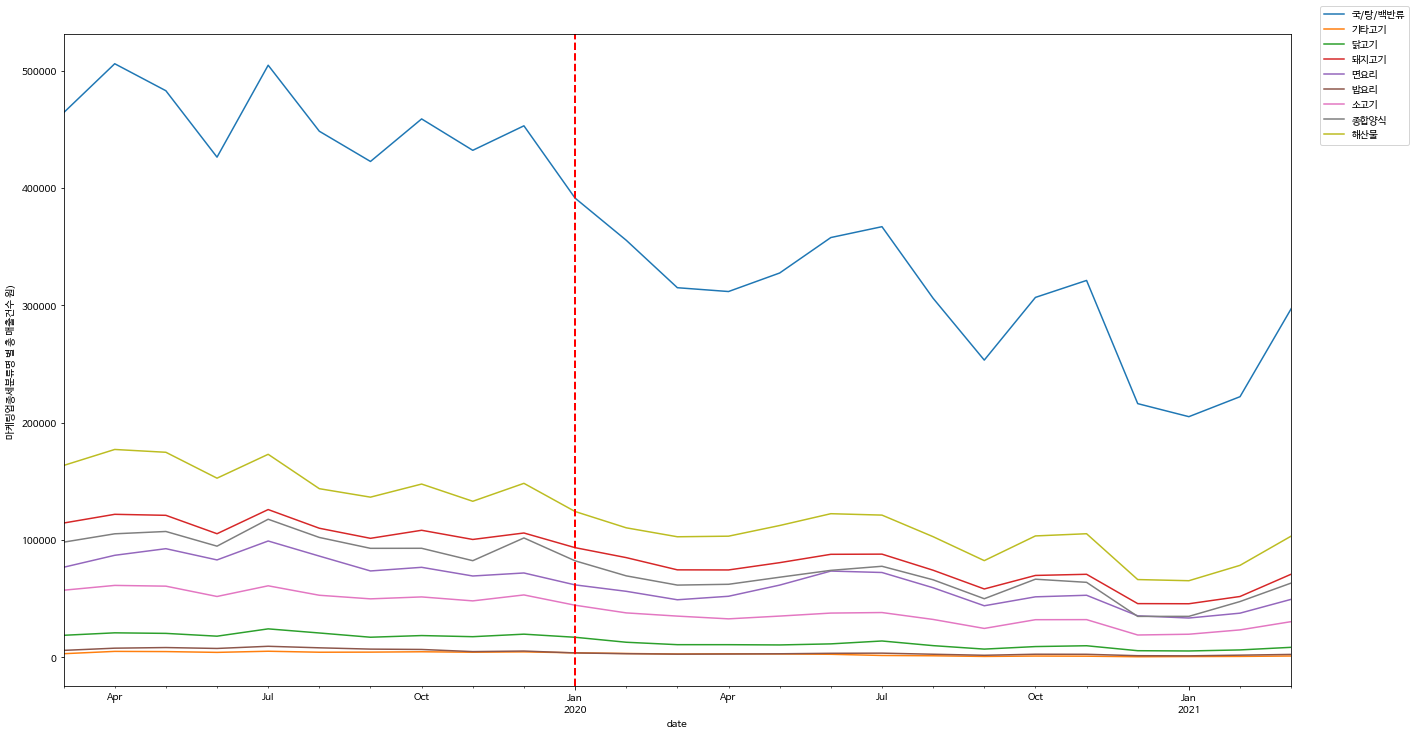

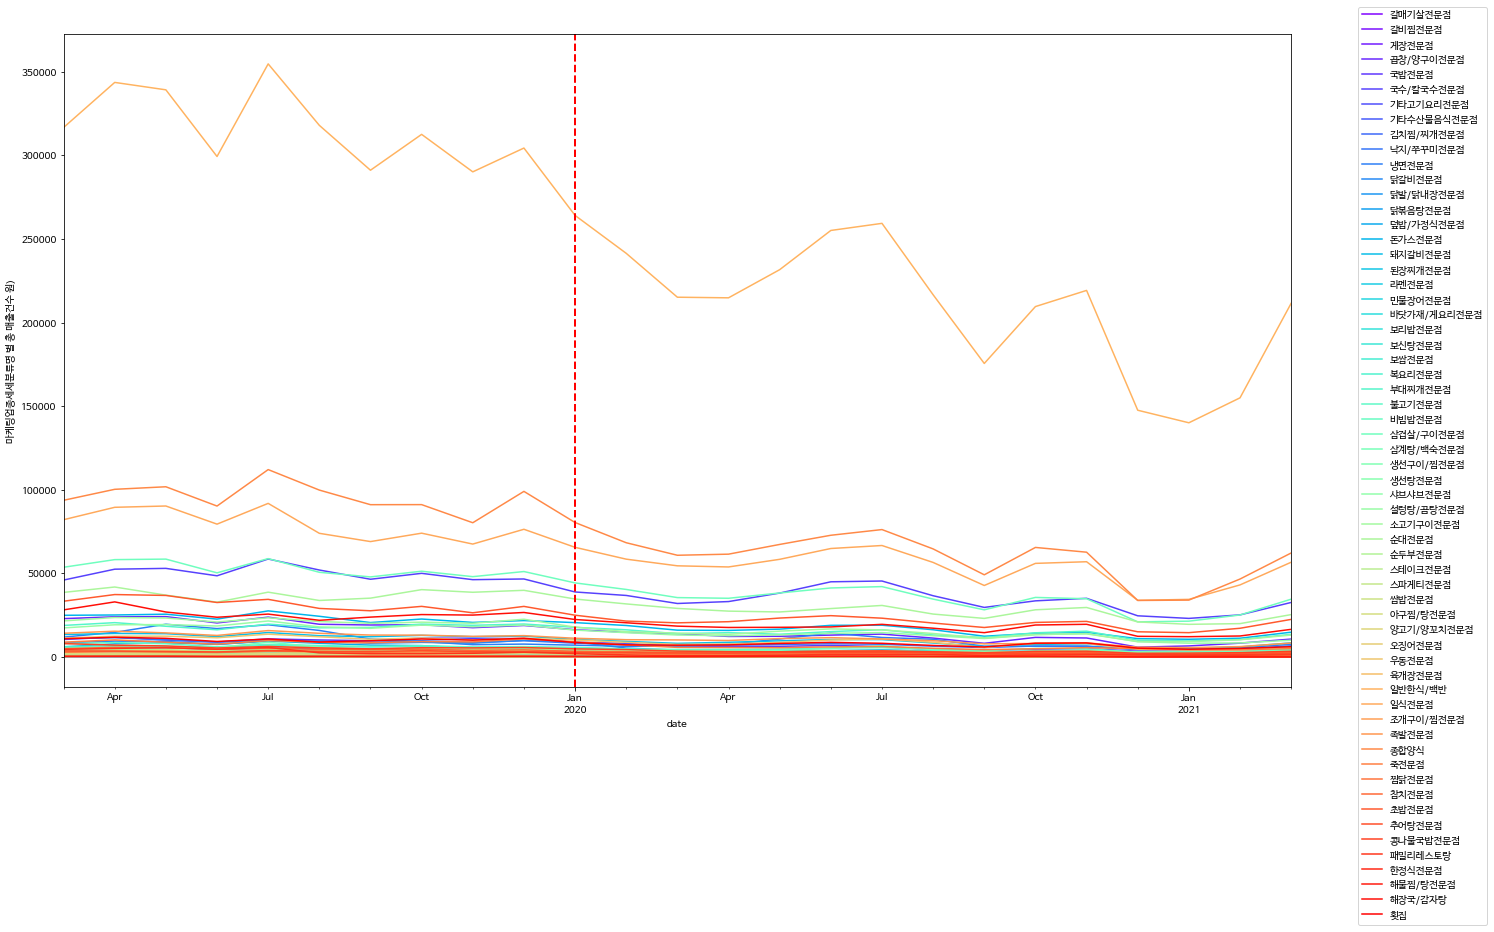

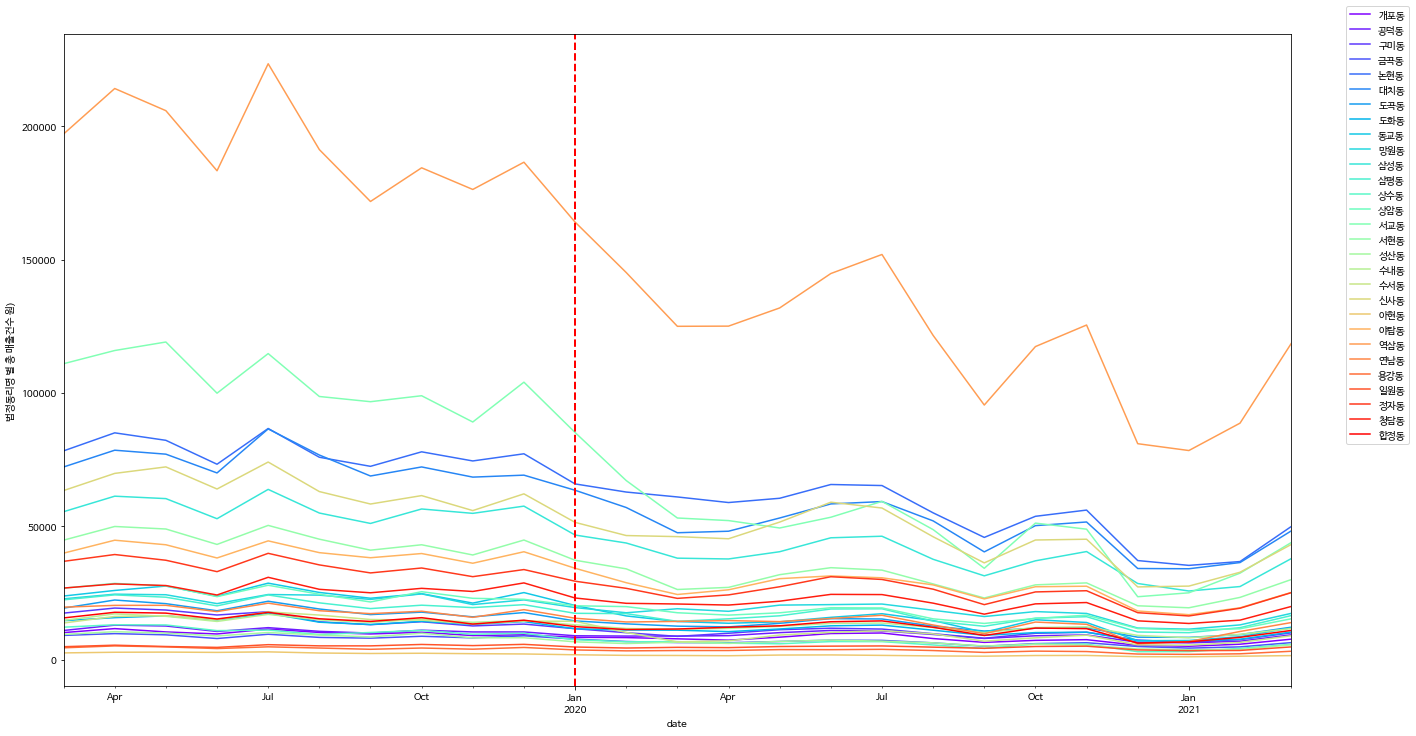

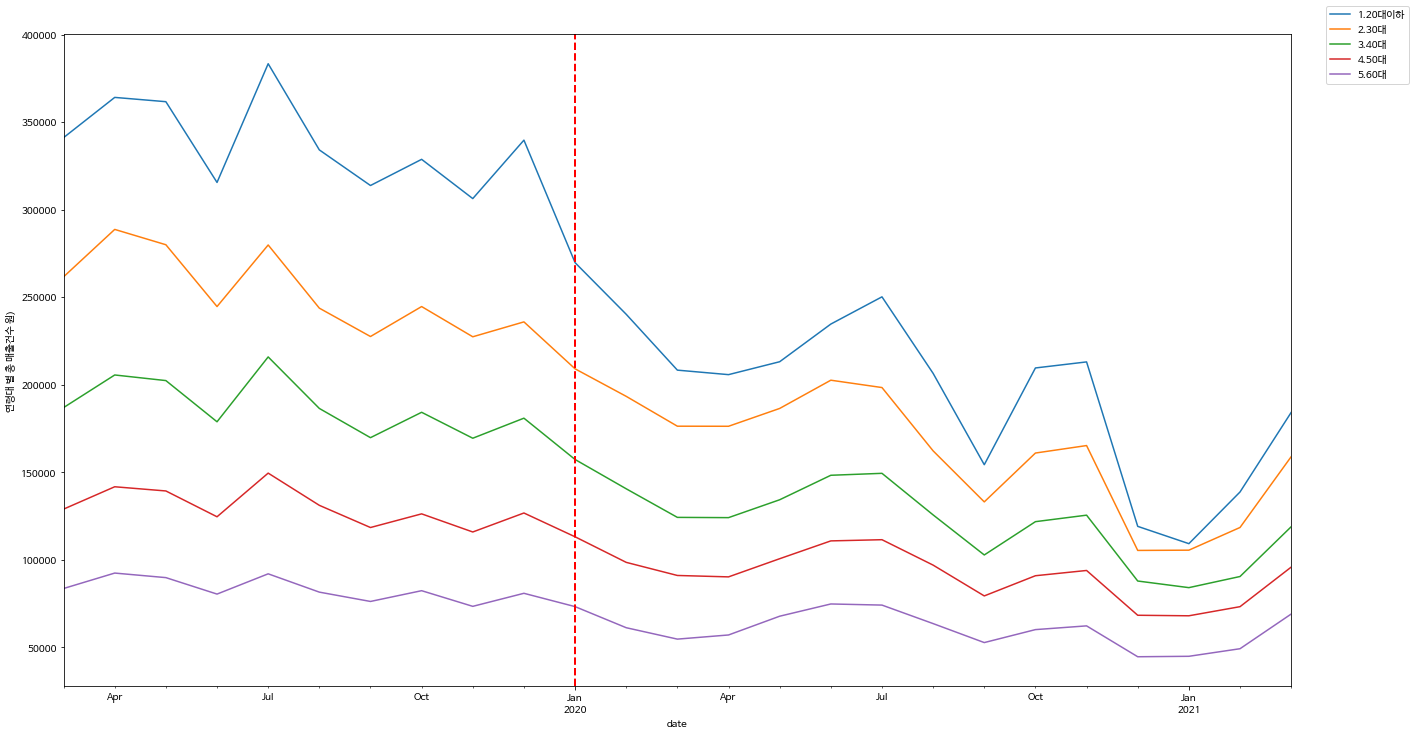

In [ ]:
from matplotlib import cm
colors = cm.get_cmap('rainbow')

data_detail_type = data.groupby(['date','마케팅업종세분류명'])['매출건수'].agg('sum')
ax1 = data_detail_type.unstack('마케팅업종세분류명', fill_value=0).plot(figsize=(22,12)).set_ylabel('마케팅업종세분류명 별 총 매출건수 원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05))

data_more_detail_type = data.groupby(['date','마케팅업종세세분류명'])['매출건수'].agg('sum')
ax2 = data_more_detail_type.unstack('마케팅업종세세분류명', fill_value=0).plot(figsize=(22,12), cmap=colors).set_ylabel('마케팅업종세세분류명 별 총 매출건수 원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.05, 1.05))

data_dong_type = data.groupby(['date','법정동리명'])['매출건수'].agg('sum')
ax3 = data_dong_type.unstack('법정동리명', fill_value=0).plot(figsize=(22,12), cmap=colors).set_ylabel('법정동리명 별 총 매출건수 원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05))

data_age_type = data.groupby(['date','연령대'])['매출건수'].agg('sum')
ax4 = data_age_type.unstack('연령대', fill_value=0).plot(figsize=(22,12)).set_ylabel('연령대 별 총 매출건수 원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05))

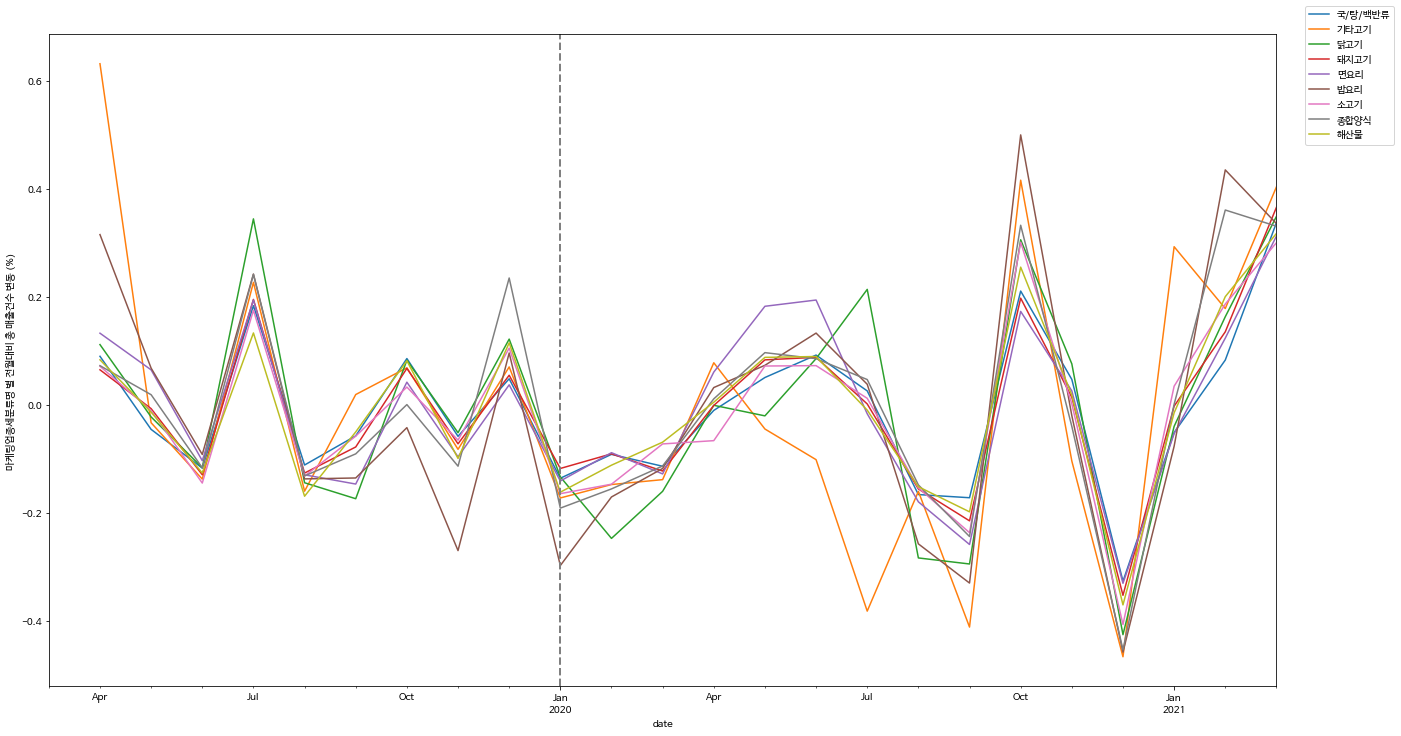

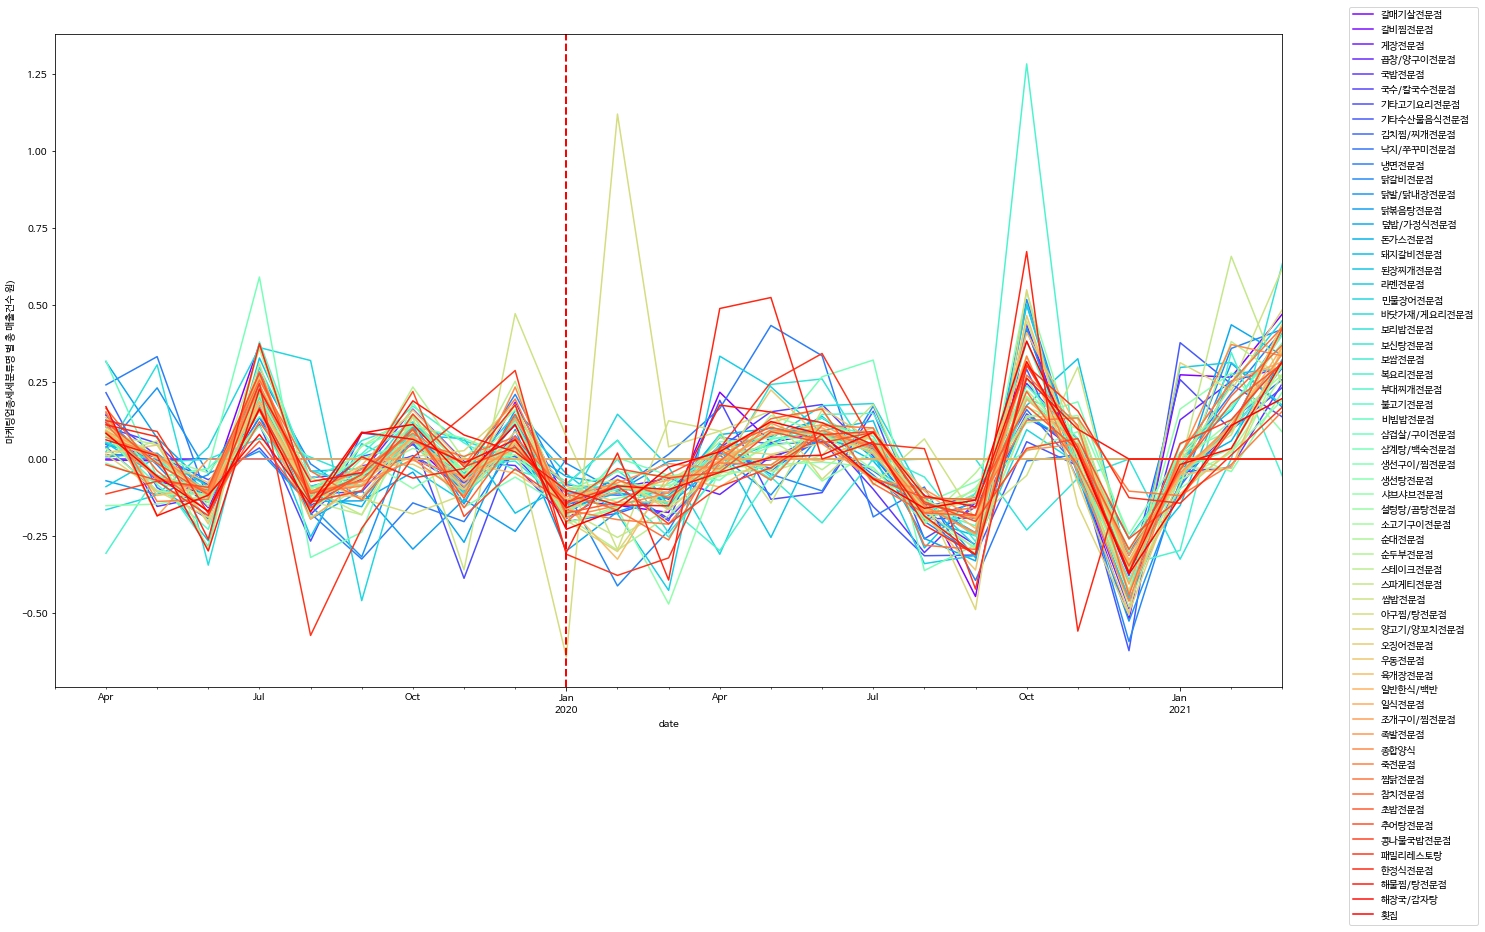

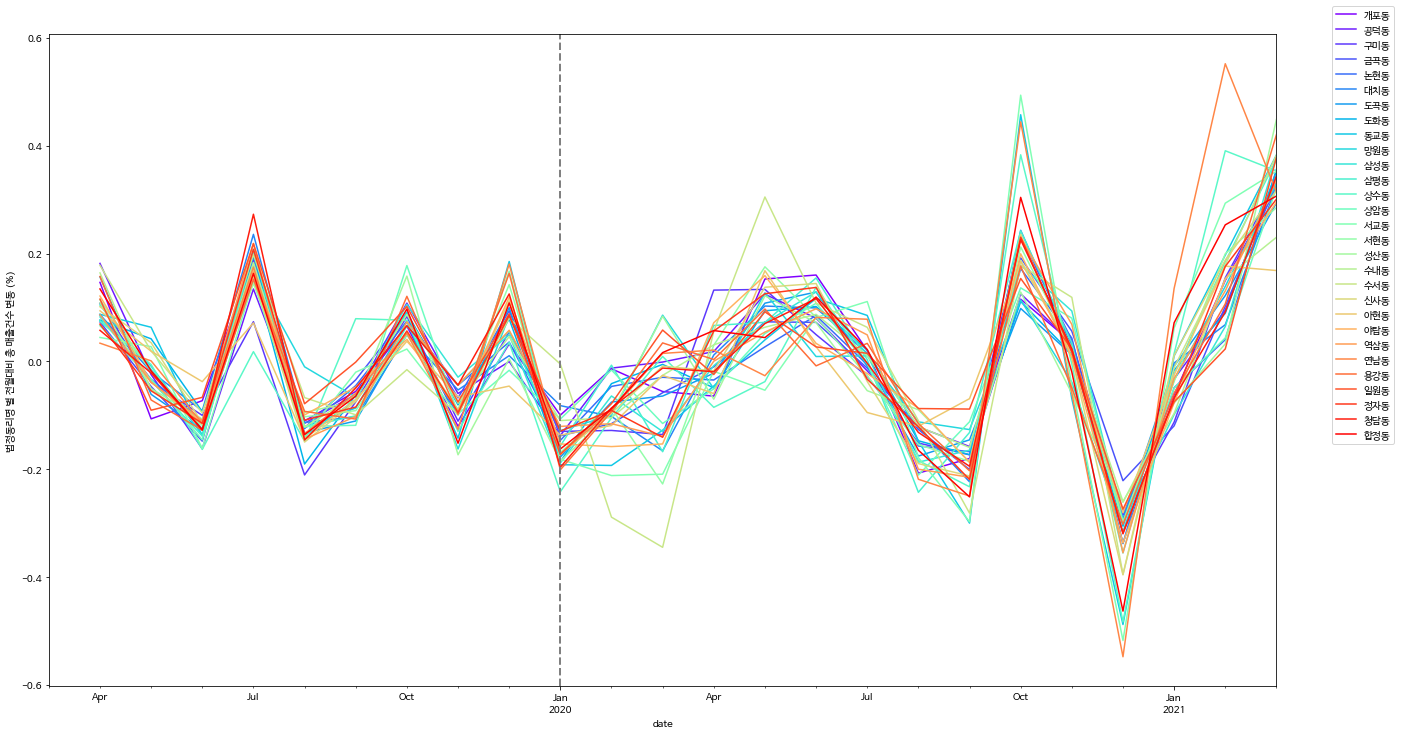

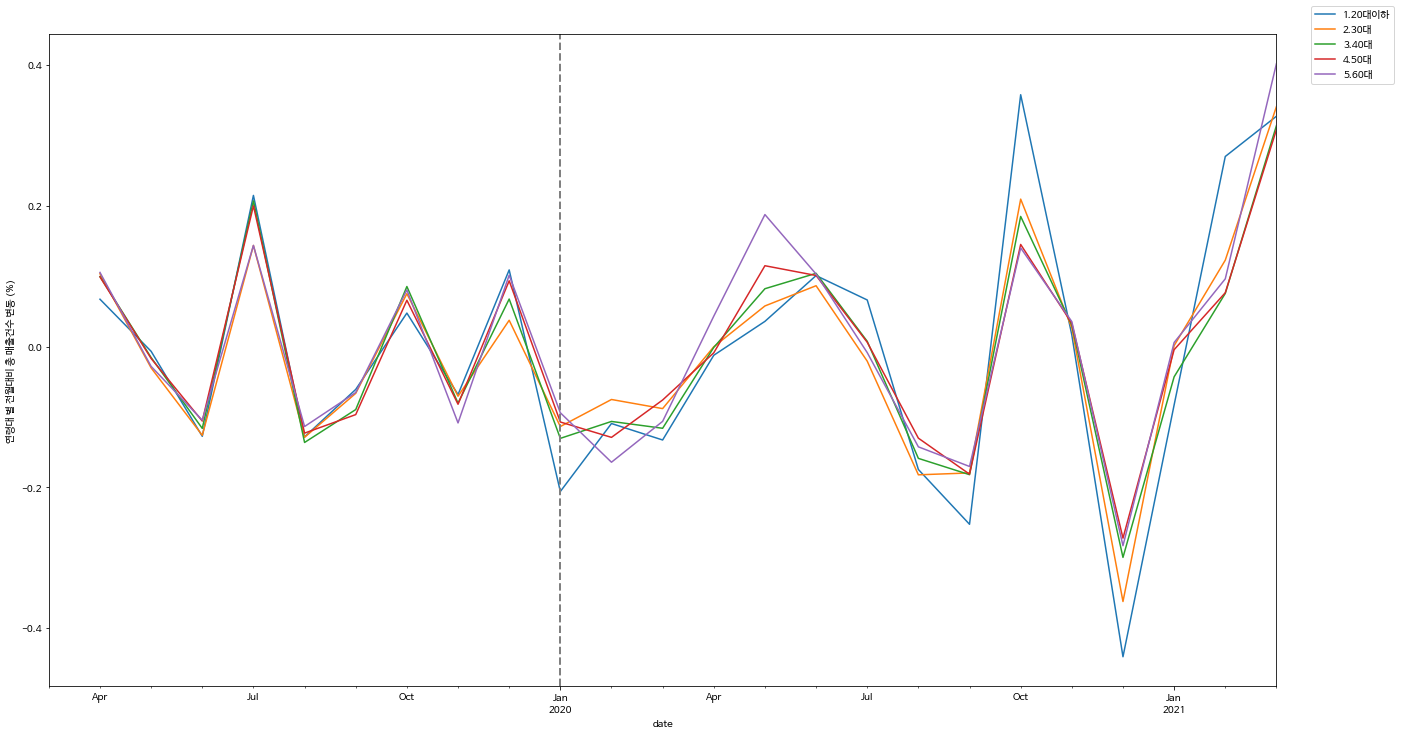

In [13]:
data_detail_type = data.groupby(['date','마케팅업종세분류명'])['매출건수'].agg('sum').groupby(['마케팅업종세분류명']).pct_change()
ax1 = data_detail_type.unstack('마케팅업종세분류명', fill_value=0).plot(figsize=(22,12)).set_ylabel('마케팅업종세분류명 별 전월대비 총 매출건수 변동 (%)')
plt.axvline(pd.to_datetime('2020-01-20'), color='grey', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05))

data_more_detail_type = data.groupby(['date','마케팅업종세세분류명'])['매출건수'].agg('sum').groupby(['마케팅업종세세분류명']).pct_change()
ax2 = data_more_detail_type.unstack('마케팅업종세세분류명', fill_value=0).plot(figsize=(22,12), cmap=colors).set_ylabel('마케팅업종세세분류명 별 총 매출건수 원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.05, 1.05))

data_dong_type = data.groupby(['date','법정동리명'])['매출건수'].agg('sum').groupby(['법정동리명']).pct_change()
ax3 = data_dong_type.unstack('법정동리명', fill_value=0).plot(figsize=(22,12), cmap=colors).set_ylabel('법정동리명 별 전월대비 총 매출건수 변동 (%)')
plt.axvline(pd.to_datetime('2020-01-20'), color='grey', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05))

data_age_type = data.groupby(['date','연령대'])['매출건수'].agg('sum').groupby(['연령대']).pct_change()
ax4 = data_age_type.unstack('연령대', fill_value=0).plot(figsize=(22,12)).set_ylabel('연령대 별 전월대비 총 매출건수 변동 (%)')
plt.axvline(pd.to_datetime('2020-01-20'), color='grey', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05))

## More detailed 시간별 총 매출건수

마케팅업종세세분류명는 항목들이 많아, 마케팅업종세분류명 별로 그래프를 그렸습니다.

On January of 2020, 아구찜/탕 전문점 experienced the biggest volatility in terms of cumulative sales volume (-0.65%) . On Febuary of 2020, the cumulative sales volume for 아구찜/탕 전문점 rebounced by a little over 1%.

On October of 2020, 북요리 전문점 experienced the biggest rebounced of over 1% in terms of cumulative sales volume. 

Text(0.5, 1.0, '마케팅업종세분류명 = 소고기')

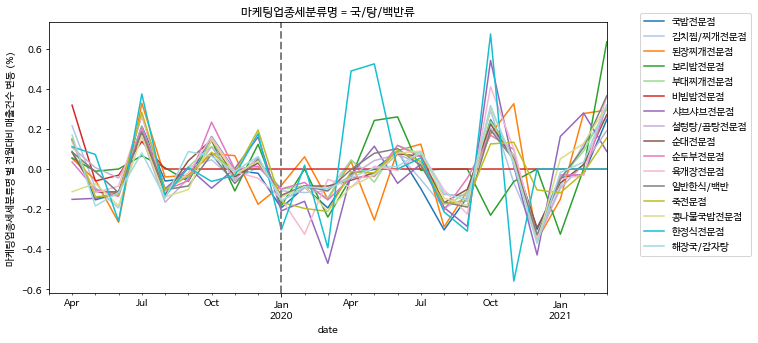

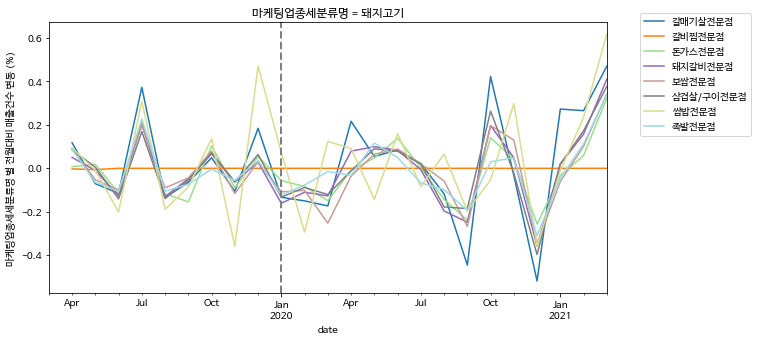

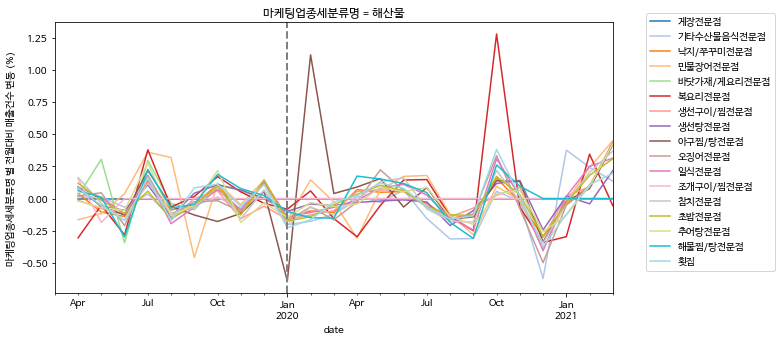

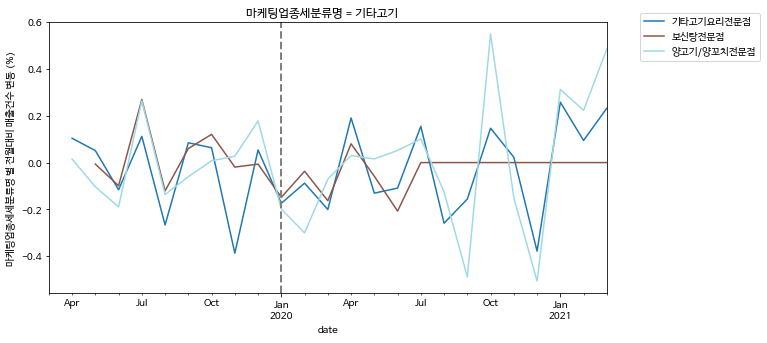

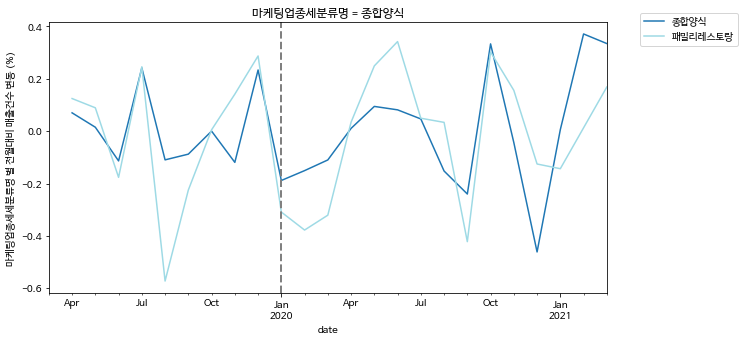

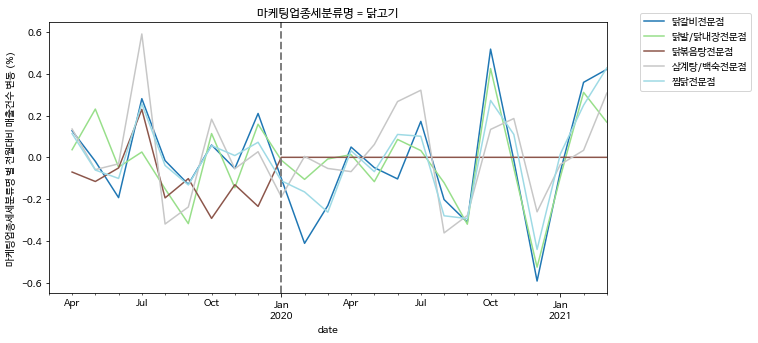

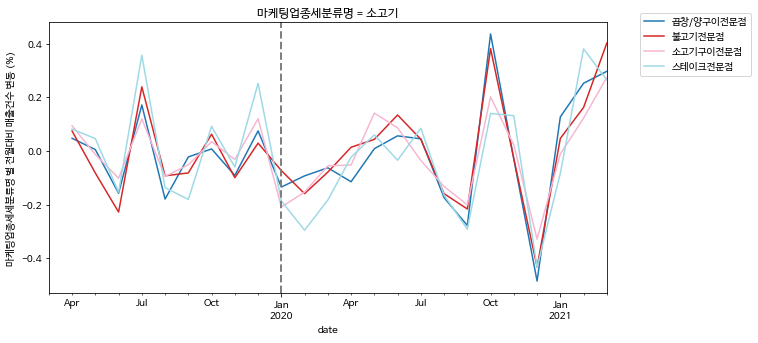

In [ ]:
data_more_detail_국탕백반류 = data[data['마케팅업종세분류명']=='국/탕/백반류']

d= data_more_detail_국탕백반류.groupby(['date','마케팅업종세세분류명'])['매출건수'].agg('sum').groupby(['마케팅업종세세분류명']).pct_change()
ax2 = d.unstack('마케팅업종세세분류명', fill_value=0).plot(figsize=(10,5), cmap=colors).set_ylabel('마케팅업종세세분류명 별 전월대비 매출건수 변동 (%)')
plt.axvline(pd.to_datetime('2020-01-20'), color='grey', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.title('마케팅업종세분류명 = 국/탕/백반류')

data_more_detail_돼지고기 = data[data['마케팅업종세분류명']=='돼지고기']

d= data_more_detail_돼지고기.groupby(['date','마케팅업종세세분류명'])['매출건수'].agg('sum').groupby(['마케팅업종세세분류명']).pct_change()
ax2 = d.unstack('마케팅업종세세분류명', fill_value=0).plot(figsize=(10,5), cmap=colors).set_ylabel('마케팅업종세세분류명 별 전월대비 매출건수 변동 (%)')
plt.axvline(pd.to_datetime('2020-01-20'), color='grey', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.title('마케팅업종세분류명 = 돼지고기')

colors = cm.get_cmap('tab20')

data_more_detail_해산물 = data[data['마케팅업종세분류명']=='해산물']

d= data_more_detail_해산물.groupby(['date','마케팅업종세세분류명'])['매출건수'].agg('sum').groupby(['마케팅업종세세분류명']).pct_change()
ax2 = d.unstack('마케팅업종세세분류명', fill_value=0).plot(figsize=(10,5), cmap=colors).set_ylabel('마케팅업종세세분류명 별 전월대비 매출건수 변동 (%)')
plt.axvline(pd.to_datetime('2020-01-20'), color='grey', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.title('마케팅업종세분류명 = 해산물')


data_more_detail_기타고기	 = data[data['마케팅업종세분류명']=='기타고기']

d= data_more_detail_기타고기.groupby(['date','마케팅업종세세분류명'])['매출건수'].agg('sum').groupby(['마케팅업종세세분류명']).pct_change()
ax2 = d.unstack('마케팅업종세세분류명', fill_value=0).plot(figsize=(10,5), cmap=colors).set_ylabel('마케팅업종세세분류명 별 전월대비 매출건수 변동 (%)')
plt.axvline(pd.to_datetime('2020-01-20'), color='grey', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.title('마케팅업종세분류명 = 기타고기	')


data_more_detail_종합양식 = data[data['마케팅업종세분류명']=='종합양식']

d= data_more_detail_종합양식.groupby(['date','마케팅업종세세분류명'])['매출건수'].agg('sum').groupby(['마케팅업종세세분류명']).pct_change()
ax2 = d.unstack('마케팅업종세세분류명', fill_value=0).plot(figsize=(10,5), cmap=colors).set_ylabel('마케팅업종세세분류명 별 전월대비 매출건수 변동 (%)')
plt.axvline(pd.to_datetime('2020-01-20'), color='grey', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.title('마케팅업종세분류명 = 종합양식')


data_more_detail_닭고기	 = data[data['마케팅업종세분류명']=='닭고기']

d= data_more_detail_닭고기.groupby(['date','마케팅업종세세분류명'])['매출건수'].agg('sum').groupby(['마케팅업종세세분류명']).pct_change()
ax2 = d.unstack('마케팅업종세세분류명', fill_value=0).plot(figsize=(10,5), cmap=colors).set_ylabel('마케팅업종세세분류명 별 전월대비 매출건수 변동 (%)')
plt.axvline(pd.to_datetime('2020-01-20'), color='grey', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.title('마케팅업종세분류명 = 닭고기')

data_more_detail_소고기 = data[data['마케팅업종세분류명']=='소고기']

d= data_more_detail_소고기.groupby(['date','마케팅업종세세분류명'])['매출건수'].agg('sum').groupby(['마케팅업종세세분류명']).pct_change()
ax2 = d.unstack('마케팅업종세세분류명', fill_value=0).plot(figsize=(10,5), cmap=colors).set_ylabel('마케팅업종세세분류명 별 전월대비 매출건수 변동 (%)')
plt.axvline(pd.to_datetime('2020-01-20'), color='grey', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.05, 1.05))
plt.title('마케팅업종세분류명 = 소고기')





## 총 매출건수 변화량 Heatmap 

총 매출건수 변화량을 나타내기 위해 분류별로 전월대비 % 변화량을 계산했습니다. 

To show the change in Total monthly sales volume, a heatmap was created.Positive changes are denoted in green color while negative changes are in red. 

As an example, 2020-12 was the period of greatest decrease. This sharp sales decrease is a phenomenon universally seen across all categories and seoul locations, and can be seen easily by the distinguished red colored tiles on 2020-12. Interestingly, this time period was the more severe in terms of % change in 매출건수, when even when compared to first covid wave in 2020-01. 

On 2020-12-08, Korea announced stricter quarantine rules due to the third wave resurgence of COVID cases. The raised standards of 2.5 단계 involved restrictions on gathering of at least 10 people. All resteraunt businesses in all seoul areas were heavily effected by this new restriction, wtih 연남동 and 서교동 being hit the worst. 

Afterwards by 2021-03, most categories of total sales volume rebounced and experienced a sharp increase of sales. However, in terms of total and mean 매출건수, none of the categories of resteraunts recovered to pre-pandemic levels. None of the seoul areas recovered as well.

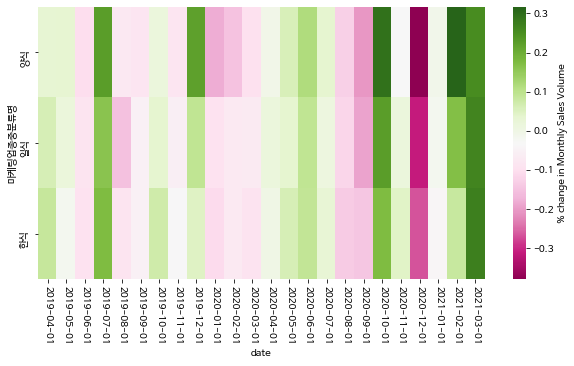

In [16]:
d = data.groupby(['date','마케팅업종중분류명'])['매출건수'].agg('mean').groupby(['마케팅업종중분류명']).pct_change()

df = pd.DataFrame(d).reset_index().pivot_table(index="마케팅업종중분류명", columns="date", values="매출건수")

f, axes = plt.subplots(1, 1, figsize=(10,5))
ax = sns.heatmap(df, cbar_kws={'label': '% change in Monthly Sales Volume'}, cmap="PiYG")

ax.set_xticklabels(df.iloc[0].index.strftime('%Y-%m-%d'))
plt.xticks(rotation=-90)

plt.show()


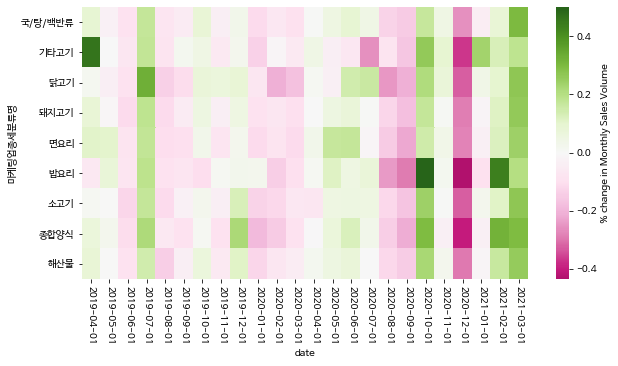

In [17]:
d = data.groupby(['date','마케팅업종세분류명'])['매출건수'].agg('mean').groupby(['마케팅업종세분류명']).pct_change()

df = pd.DataFrame(d).reset_index().pivot_table(index="마케팅업종세분류명", columns="date", values="매출건수")

f, axes = plt.subplots(1, 1, figsize=(10,5))
ax = sns.heatmap(df, cbar_kws={'label': '% change in Monthly Sales Volume'}, cmap="PiYG",center=0)

ax.set_xticklabels(df.iloc[0].index.strftime('%Y-%m-%d'))
plt.xticks(rotation=-90)

plt.show()


In [ ]:
data[['마케팅업종중분류명','마케팅업종세분류명','마케팅업종세세분류명']].merge(df,on=['마케팅업종세세분류명']).drop_duplicates().sort_values(['마케팅업종중분류명','마케팅업종세분류명'])[['마케팅업종중분류명','마케팅업종세분류명','마케팅업종세세분류명']].drop_duplicates().reset_index()

index 마케팅업종중분류명 마케팅업종세분류명   마케팅업종세세분류명
0   289665        양식       면요리      스파게티전문점
1   218504        양식       소고기      스테이크전문점
2        0        양식      종합양식         종합양식
3    17321        양식      종합양식      패밀리레스토랑
4   221376        일식      돼지고기       돈가스전문점
5   283356        일식       면요리        라멘전문점
6   246833        일식       밥요리    덮밥/가정식전문점
7    18299        일식       해산물        일식전문점
8    36777        일식       해산물        참치전문점
9    43272        일식       해산물        초밥전문점
10   58118        한식   국/탕/백반류      부대찌개전문점
11   67410        한식   국/탕/백반류        순대전문점
12   80735        한식   국/탕/백반류      일반한식/백반
13  102413        한식   국/탕/백반류      해장국/감자탕
14  229784        한식   국/탕/백반류        국밥전문점
15  248599        한식   국/탕/백반류      샤브샤브전문점
16  250760        한식   국/탕/백반류    설렁탕/곰탕전문점
17  257203        한식   국/탕/백반류         죽전문점
18  270304        한식   국/탕/백반류     콩나물국밥전문점
19  284936        한식   국/탕/백반류    김치찜/찌개전문점
20  291319        한식   국/탕/백반류       순두부전문점
21  305722        한식   국/탕/백반류       육개장전문점
22  306778        한식   국/탕/백반류       한정식전문점
23  307255        한식   국/탕/백반류      된장찌개전문점
24  307874        한식   국/탕/백반류       비빔밥전문점
25  310396        한식   국/탕/백반류       보리밥전문점
26  234693        한식      기타고기   양고기/양꼬치전문점
27  287973        한식      기타고기    기타고기요리전문점
28  311169        한식      기타고기       보신탕전문점
29  112549        한식       닭고기       닭갈비전문점
30  216709        한식       닭고기    닭발/닭내장전문점
31  272910        한식       닭고기    삼계탕/백숙전문점
32  294030        한식       닭고기      닭볶음탕전문점
33  308004        한식       닭고기        찜닭전문점
34  115857        한식      돼지고기      돼지갈비전문점
35  127441        한식      돼지고기    삼겹살/구이전문점
36  146376        한식      돼지고기        족발전문점
37  277758        한식      돼지고기      갈매기살전문점
38  289147        한식      돼지고기        쌈밥전문점
39  294389        한식      돼지고기        보쌈전문점
40  310896        한식      돼지고기       갈비찜전문점
41  158069        한식       면요리    국수/칼국수전문점
42  236951        한식       면요리        냉면전문점
43  297885        한식       면요리        우동전문점
44  174743        한식       소고기    곱창/양구이전문점
45  187269        한식       소고기     소고기구이전문점
46  300505        한식       소고기       불고기전문점
47  197153        한식       해산물    낙지/쭈꾸미전문점
48  207002        한식       해산물           횟집
49  243874        한식       해산물       오징어전문점
50  263772        한식       해산물   기타수산물음식전문점
51  267045        한식       해산물    생선구이/찜전문점
52  279612        한식       해산물     아구찜/탕전문점
53  281050        한식       해산물       추어탕전문점
54  303111        한식       해산물      민물장어전문점
55  303835        한식       해산물       생선탕전문점
56  305661        한식       해산물    조개구이/찜전문점
57  309396        한식       해산물       복요리전문점
58  309865        한식       해산물     해물찜/탕전문점
59  310959        한식       해산물  바닷가재/게요리전문점

Map of Categories Grouped

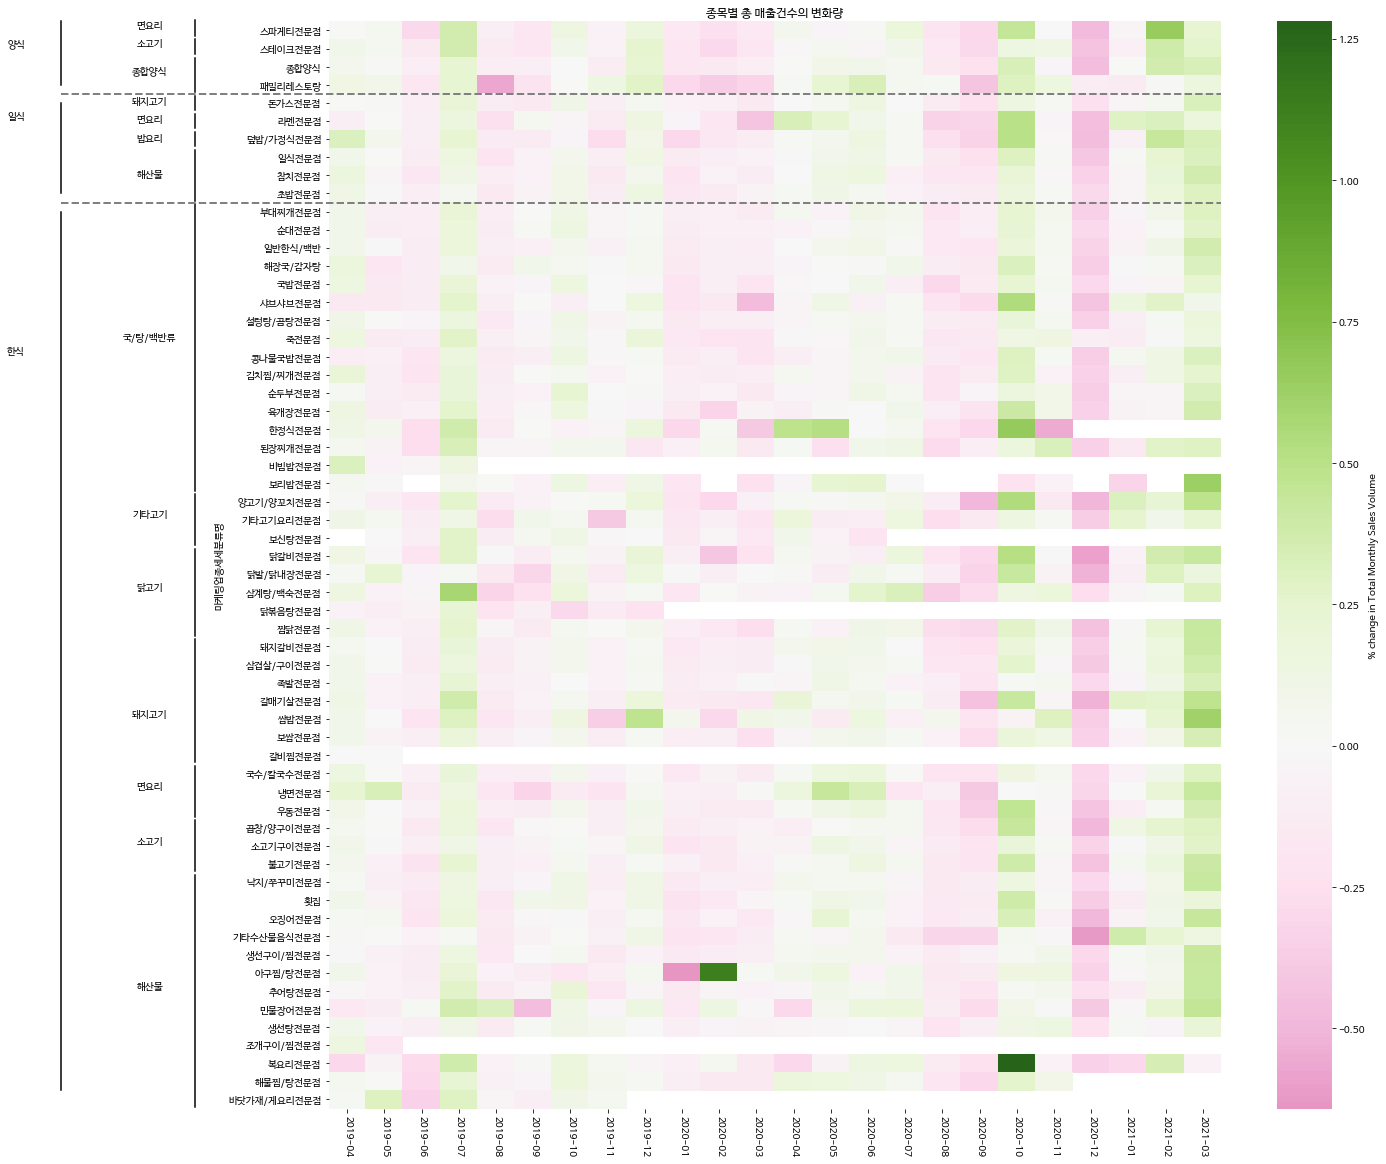

In [ ]:
d = data.groupby(['date','마케팅업종세세분류명'])['매출건수'].agg('sum').groupby(['마케팅업종세세분류명']).pct_change()

df = pd.DataFrame(d).reset_index().pivot_table(index="마케팅업종세세분류명", columns="date", values="매출건수")

df= data[['마케팅업종중분류명','마케팅업종세분류명','마케팅업종세세분류명']].merge(df,on=['마케팅업종세세분류명']).drop_duplicates().sort_values(['마케팅업종중분류명','마케팅업종세분류명']).set_index('마케팅업종세세분류명')
df = df.drop(['마케팅업종중분류명','마케팅업종세분류명'], axis=1)


f, axes = plt.subplots(1, 1, figsize=(20,20))

ax = sns.heatmap(df, cbar_kws={'label': '% change in Total Monthly Sales Volume'}, cmap="PiYG", center=0)

trans = ax.get_yaxis_transform()

# 마케팅업종중분류명
ax.annotate('양식', xy=(-0.35, 1), xycoords=trans, ha="center", va="top")
ax.plot([-0.3,-0.3],[0,3.5], color="k", transform=trans, clip_on=False)

ax.annotate('일식', xy=(-0.35, 5), xycoords=trans, ha="center", va="top")
ax.plot([-0.3,-0.3],[4.5,9.5], color="k", transform=trans, clip_on=False)

ax.annotate('한식', xy=(-0.35, 18), xycoords=trans, ha="center", va="top")
ax.plot([-0.3,-0.3],[10.5,59], color="k", transform=trans, clip_on=False)

# 마케팅업종세분류명
ax.annotate('면요리', xy=(-0.2, 0), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[-0.1,0.8], color="k", transform=trans, clip_on=False)

ax.annotate('소고기', xy=(-0.2, 1), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[1,1.8], color="k", transform=trans, clip_on=False)

ax.annotate('종합양식', xy=(-0.2, 2.5), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[2,3.9], color="k", transform=trans, clip_on=False)

ax.annotate('돼지고기', xy=(-0.2, 4.2), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[4.1,4.9], color="k", transform=trans, clip_on=False)

ax.annotate('면요리', xy=(-0.2, 5.2), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[5.1,5.9], color="k", transform=trans, clip_on=False)

ax.annotate('밥요리', xy=(-0.2, 6.2), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[6.1,6.9], color="k", transform=trans, clip_on=False)

ax.annotate('해산물', xy=(-0.2, 8.2), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[7.1,9.9], color="k", transform=trans, clip_on=False)

ax.annotate('국/탕/백반류', xy=(-0.2, 17.2), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[10.1,25.9], color="k", transform=trans, clip_on=False)

ax.annotate('기타고기', xy=(-0.2, 27), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[26.1,28.9], color="k", transform=trans, clip_on=False)

ax.annotate('닭고기', xy=(-0.2, 31), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[29.1,33.9], color="k", transform=trans, clip_on=False)

ax.annotate('돼지고기', xy=(-0.2, 38), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[34.1,40.9], color="k", transform=trans, clip_on=False)

ax.annotate('면요리', xy=(-0.2, 42), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[41.1,43.9], color="k", transform=trans, clip_on=False)

ax.annotate('소고기', xy=(-0.2, 45), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[44.1,46.9], color="k", transform=trans, clip_on=False)

ax.annotate('해산물', xy=(-0.2, 53), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[47.1,59.9], color="k", transform=trans, clip_on=False)

ax.plot([-0.3,1],[4,4], linestyle='dashed', linewidth=2, color="gray", transform=trans,clip_on=False )
ax.plot([-0.3,1],[10,10], linestyle='dashed', linewidth=2, color="gray", transform=trans,clip_on=False)

ax.set_xticklabels(df.iloc[0].index.strftime('%Y-%m'))
plt.xticks(rotation=-90)
plt.title('종목별 총 매출건수의 변화량')

plt.show()


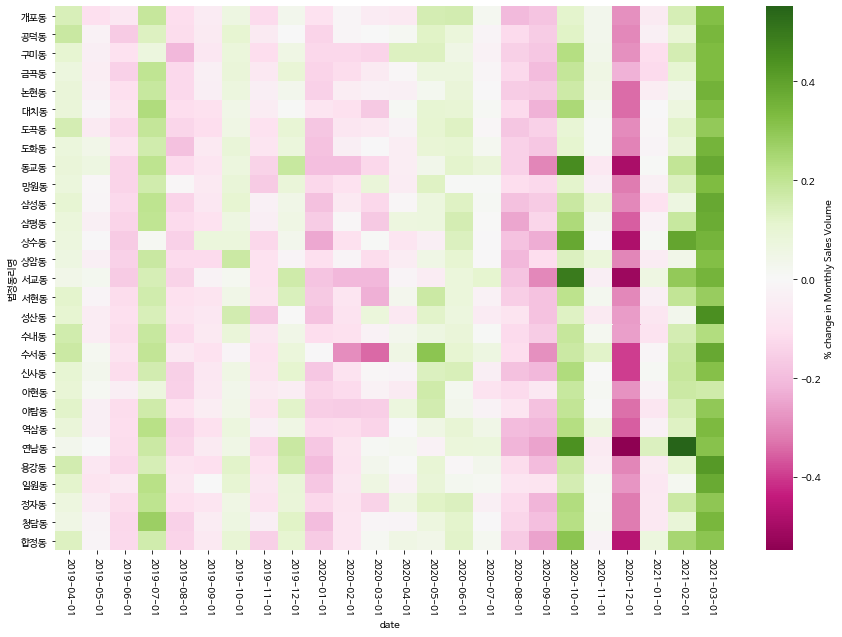

In [ ]:
d = data.groupby(['date','법정동리명'])['매출건수'].agg('sum').groupby(['법정동리명']).pct_change()

df = pd.DataFrame(d).reset_index().pivot_table(index="법정동리명", columns="date", values="매출건수")

f, axes = plt.subplots(1, 1, figsize=(15,10))
ax = sns.heatmap(df, cbar_kws={'label': '% change in Monthly Sales Volume'}, cmap="PiYG")

ax.set_xticklabels(df.iloc[0].index.strftime('%Y-%m-%d'))
plt.xticks(rotation=-90)

plt.show()

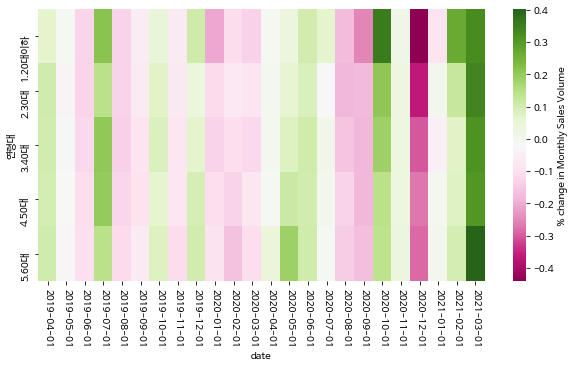

In [ ]:
d = data.groupby(['date','연령대'])['매출건수'].agg('sum').groupby(['연령대']).pct_change()

df = pd.DataFrame(d).reset_index().pivot_table(index="연령대", columns="date", values="매출건수")

f, axes = plt.subplots(1, 1, figsize=(10,5))
ax = sns.heatmap(df, cbar_kws={'label': '% change in Monthly Sales Volume'}, cmap="PiYG")

ax.set_xticklabels(df.iloc[0].index.strftime('%Y-%m-%d'))
plt.xticks(rotation=-90)

plt.show()

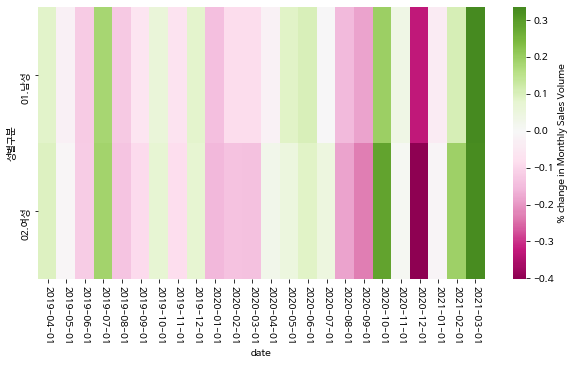

In [ ]:
d = data.groupby(['date','성별구분'])['매출건수'].agg('sum').groupby(['성별구분']).pct_change()

df = pd.DataFrame(d).reset_index().pivot_table(index="성별구분", columns="date", values="매출건수")

f, axes = plt.subplots(1, 1, figsize=(10,5))
ax = sns.heatmap(df, cbar_kws={'label': '% change in Monthly Sales Volume'}, cmap="PiYG", center=0)

ax.set_xticklabels(df.iloc[0].index.strftime('%Y-%m-%d'))
plt.xticks(rotation=-90)

plt.show()

# 시간별 평균 매출건수

국/탕/밴반류 and 종합양식 had the highest average 매출건수 over time. 

Amongst 국/탕/밴반류, 일반한식/백반 on average had the highest average 매출건수 over time, followed by 종합양식.

Average 매출건수 was perpetually decreased after COVID, with 수서동 and 서교동 being the most heavily effected.

아현동 has the lowest average 매출건수 across all time periods. 

High volatility areas in seoul experienced the biggest average decrease or increase in 매출건수. The areas with the highest volatility are 연남동, 서교동, 동교동, 합정동, and 상수동.

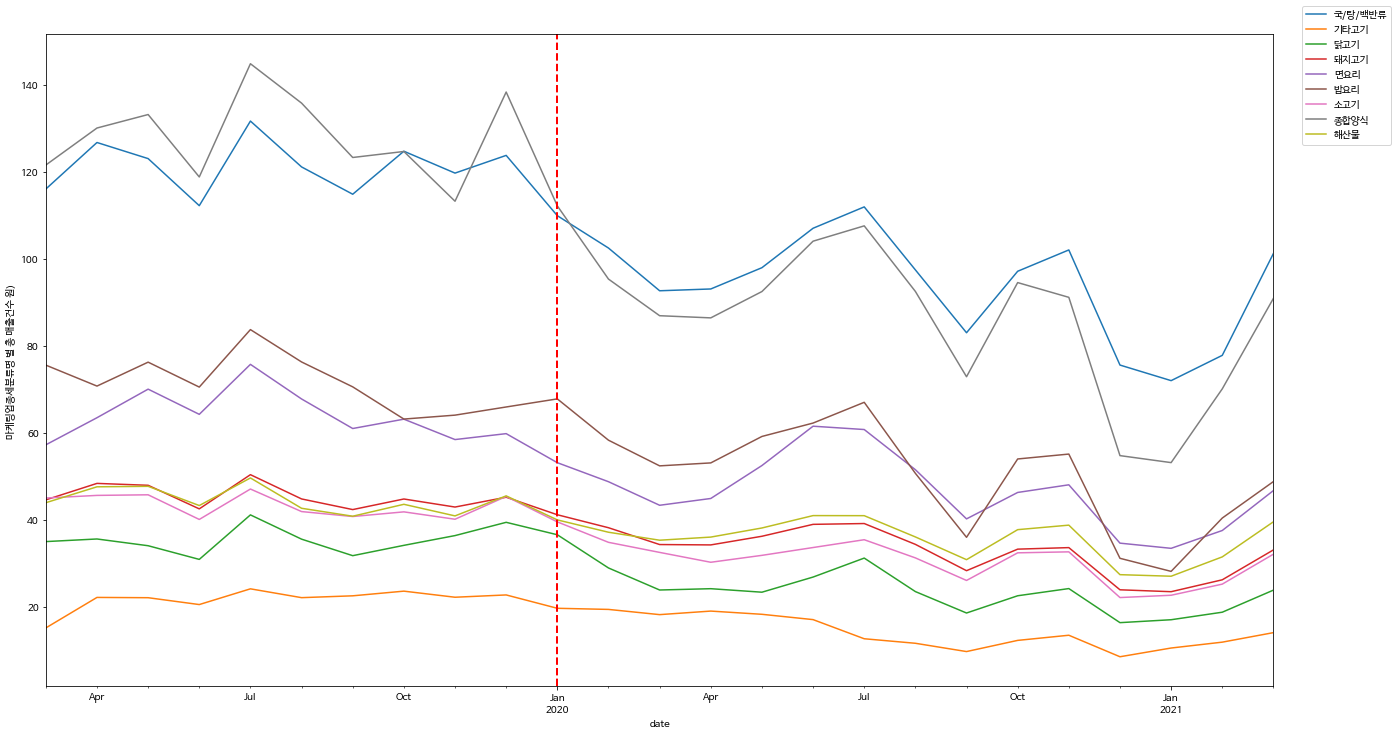

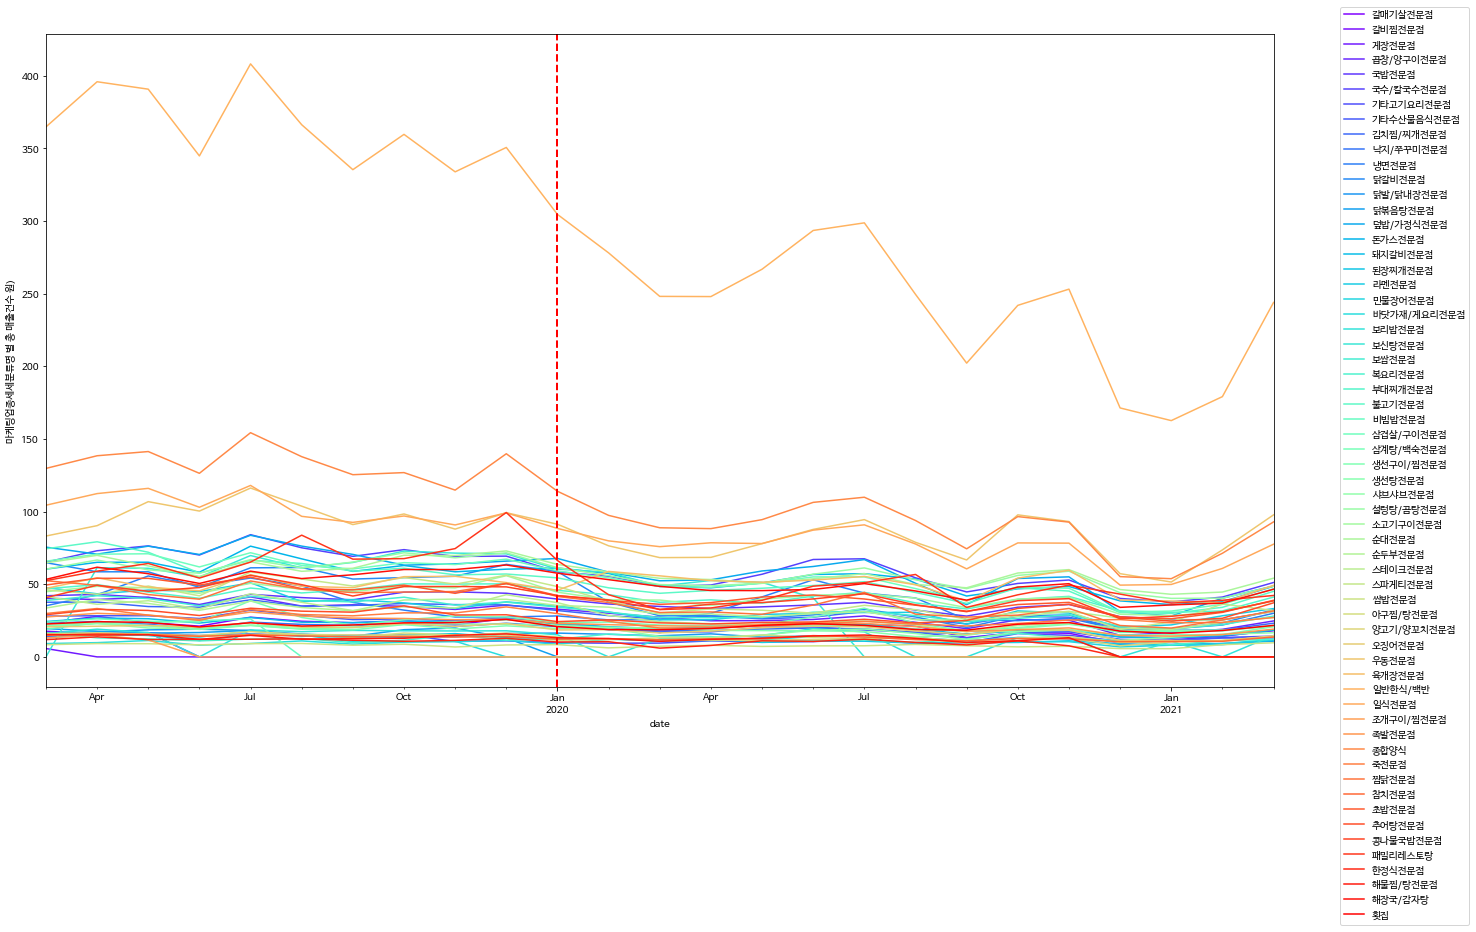

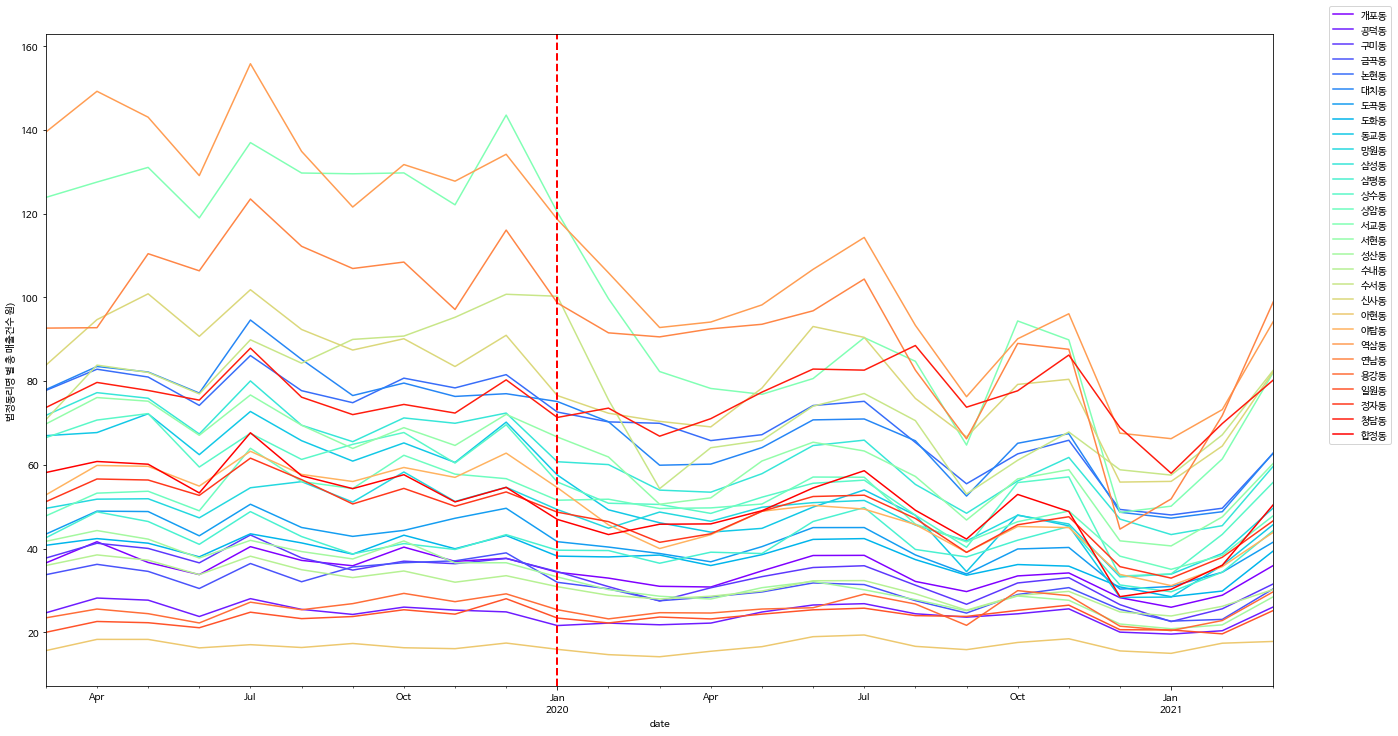

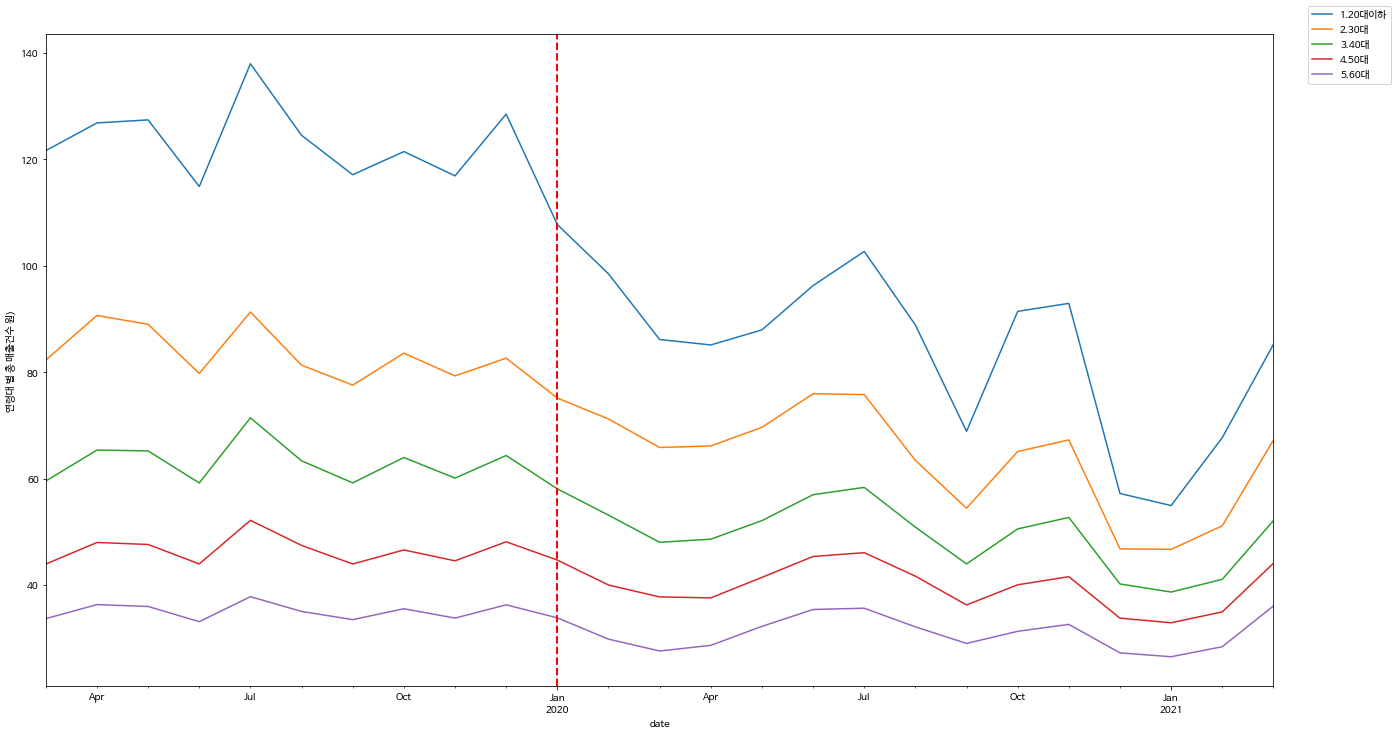

In [ ]:
from matplotlib import cm
colors = cm.get_cmap('rainbow')

data_detail_type = data.groupby(['date','마케팅업종세분류명'])['매출건수'].agg('mean')
ax1 = data_detail_type.unstack('마케팅업종세분류명', fill_value=0).plot(figsize=(22,12)).set_ylabel('마케팅업종세분류명 별 총 매출건수 원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05))

data_more_detail_type = data.groupby(['date','마케팅업종세세분류명'])['매출건수'].agg('mean')
ax2 = data_more_detail_type.unstack('마케팅업종세세분류명', fill_value=0).plot(figsize=(22,12), cmap=colors).set_ylabel('마케팅업종세세분류명 별 총 매출건수 원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.05, 1.05))

data_dong_type = data.groupby(['date','법정동리명'])['매출건수'].agg('mean')
ax3 = data_dong_type.unstack('법정동리명', fill_value=0).plot(figsize=(22,12), cmap=colors).set_ylabel('법정동리명 별 총 매출건수 원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05))

data_age_type = data.groupby(['date','연령대'])['매출건수'].agg('mean')
ax4 = data_age_type.unstack('연령대', fill_value=0).plot(figsize=(22,12)).set_ylabel('연령대 별 총 매출건수 원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05))

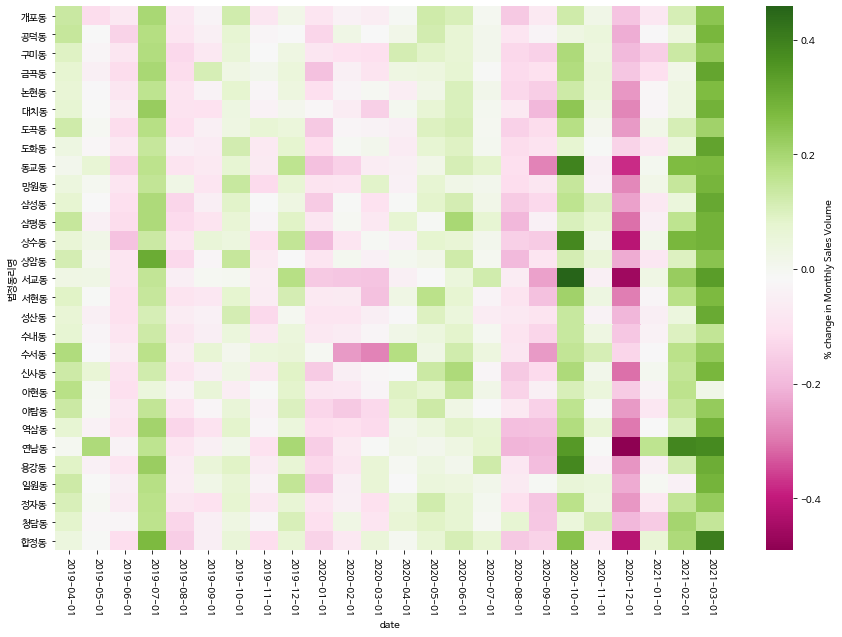

In [ ]:
d = data.groupby(['date','법정동리명'])['매출건수'].agg('mean').groupby(['법정동리명']).pct_change()

df = pd.DataFrame(d).reset_index().pivot_table(index="법정동리명", columns="date", values="매출건수")

f, axes = plt.subplots(1, 1, figsize=(15,10))
ax = sns.heatmap(df, cbar_kws={'label': '% change in Monthly Sales Volume'}, cmap="PiYG")

ax.set_xticklabels(df.iloc[0].index.strftime('%Y-%m-%d'))
plt.xticks(rotation=-90)

plt.show()

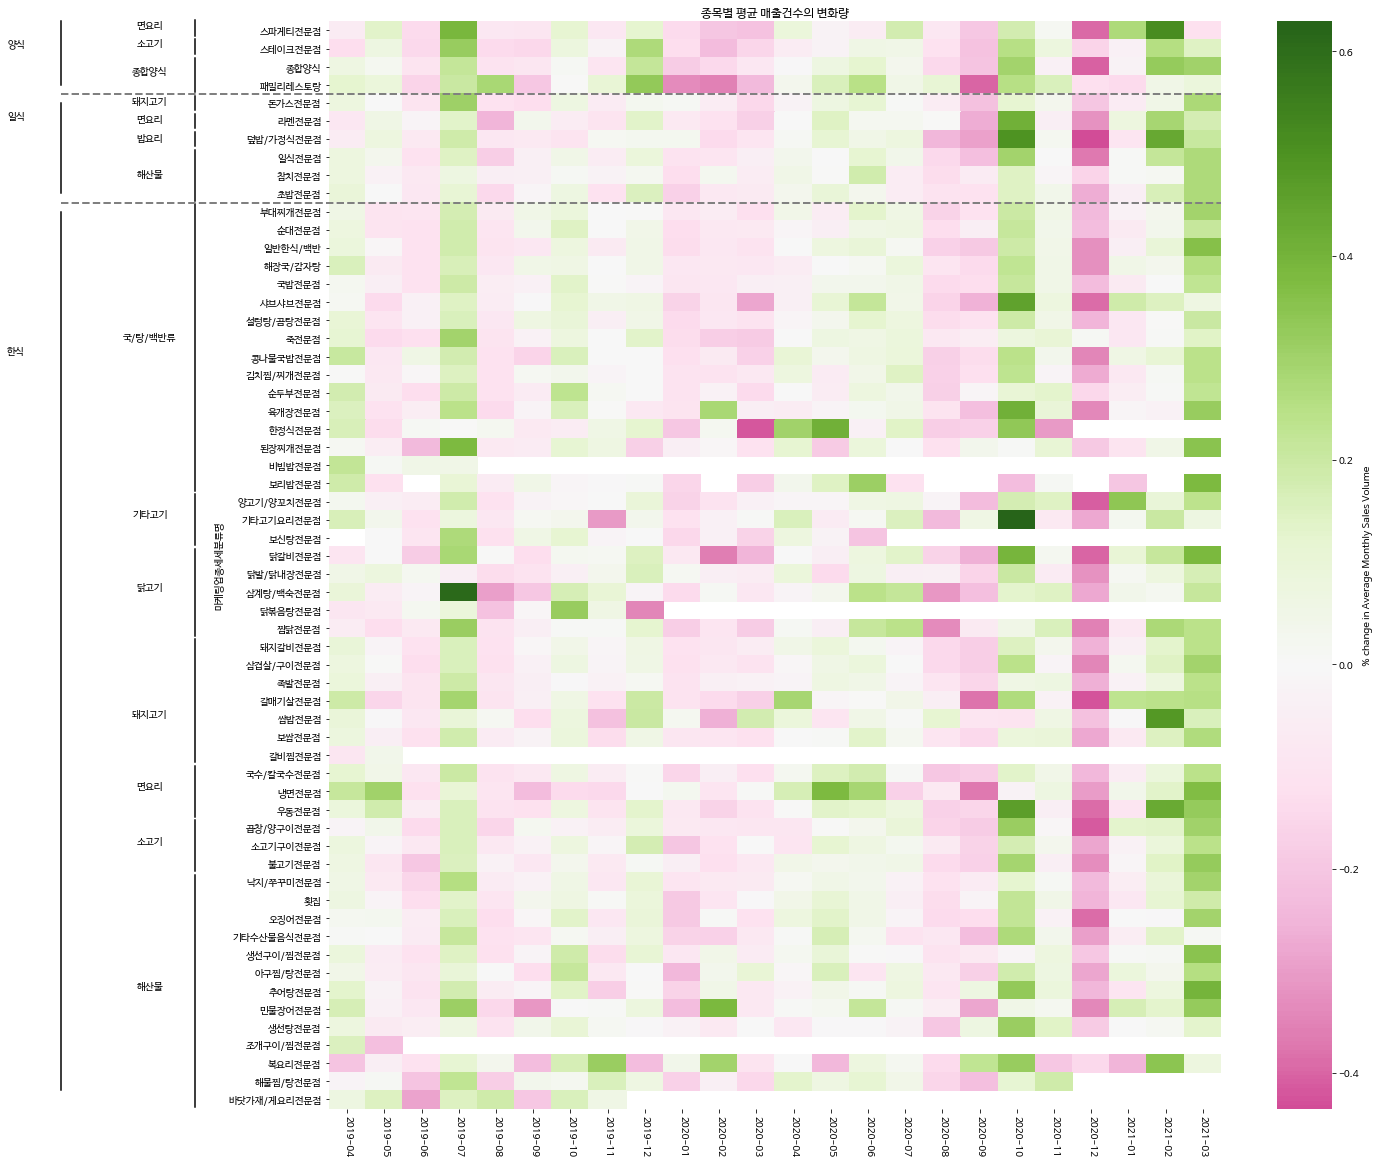

In [ ]:
d = data.groupby(['date','마케팅업종세세분류명'])['매출건수'].agg('mean').groupby(['마케팅업종세세분류명']).pct_change()

df = pd.DataFrame(d).reset_index().pivot_table(index="마케팅업종세세분류명", columns="date", values="매출건수")

df= data[['마케팅업종중분류명','마케팅업종세분류명','마케팅업종세세분류명']].merge(df,on=['마케팅업종세세분류명']).drop_duplicates().sort_values(['마케팅업종중분류명','마케팅업종세분류명']).set_index('마케팅업종세세분류명')
df = df.drop(['마케팅업종중분류명','마케팅업종세분류명'], axis=1)


f, axes = plt.subplots(1, 1, figsize=(20,20))

ax = sns.heatmap(df, cbar_kws={'label': '% change in Average Monthly Sales Volume'},cmap="PiYG", center=0)

trans = ax.get_yaxis_transform()

# 마케팅업종중분류명
ax.annotate('양식', xy=(-0.35, 1), xycoords=trans, ha="center", va="top")
ax.plot([-0.3,-0.3],[0,3.5], color="k", transform=trans, clip_on=False)

ax.annotate('일식', xy=(-0.35, 5), xycoords=trans, ha="center", va="top")
ax.plot([-0.3,-0.3],[4.5,9.5], color="k", transform=trans, clip_on=False)

ax.annotate('한식', xy=(-0.35, 18), xycoords=trans, ha="center", va="top")
ax.plot([-0.3,-0.3],[10.5,59], color="k", transform=trans, clip_on=False)

# 마케팅업종세분류명
ax.annotate('면요리', xy=(-0.2, 0), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[-0.1,0.8], color="k", transform=trans, clip_on=False)

ax.annotate('소고기', xy=(-0.2, 1), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[1,1.8], color="k", transform=trans, clip_on=False)

ax.annotate('종합양식', xy=(-0.2, 2.5), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[2,3.9], color="k", transform=trans, clip_on=False)

ax.annotate('돼지고기', xy=(-0.2, 4.2), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[4.1,4.9], color="k", transform=trans, clip_on=False)

ax.annotate('면요리', xy=(-0.2, 5.2), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[5.1,5.9], color="k", transform=trans, clip_on=False)

ax.annotate('밥요리', xy=(-0.2, 6.2), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[6.1,6.9], color="k", transform=trans, clip_on=False)

ax.annotate('해산물', xy=(-0.2, 8.2), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[7.1,9.9], color="k", transform=trans, clip_on=False)

ax.annotate('국/탕/백반류', xy=(-0.2, 17.2), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[10.1,25.9], color="k", transform=trans, clip_on=False)

ax.annotate('기타고기', xy=(-0.2, 27), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[26.1,28.9], color="k", transform=trans, clip_on=False)

ax.annotate('닭고기', xy=(-0.2, 31), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[29.1,33.9], color="k", transform=trans, clip_on=False)

ax.annotate('돼지고기', xy=(-0.2, 38), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[34.1,40.9], color="k", transform=trans, clip_on=False)

ax.annotate('면요리', xy=(-0.2, 42), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[41.1,43.9], color="k", transform=trans, clip_on=False)

ax.annotate('소고기', xy=(-0.2, 45), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[44.1,46.9], color="k", transform=trans, clip_on=False)

ax.annotate('해산물', xy=(-0.2, 53), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[47.1,59.9], color="k", transform=trans, clip_on=False)

ax.plot([-0.3,1],[4,4], linestyle='dashed', linewidth=2, color="gray", transform=trans,clip_on=False )
ax.plot([-0.3,1],[10,10], linestyle='dashed', linewidth=2, color="gray", transform=trans,clip_on=False)

ax.set_xticklabels(df.iloc[0].index.strftime('%Y-%m'))
plt.xticks(rotation=-90)
plt.title('종목별 평균 매출건수의 변화량')

plt.show()


# 시간별 매출건수 중앙값

For highly skewed data, median (50% percentile) may be a better representative statistics parameter than mean. For data skewed to low values, the median will be lower than the mean. 

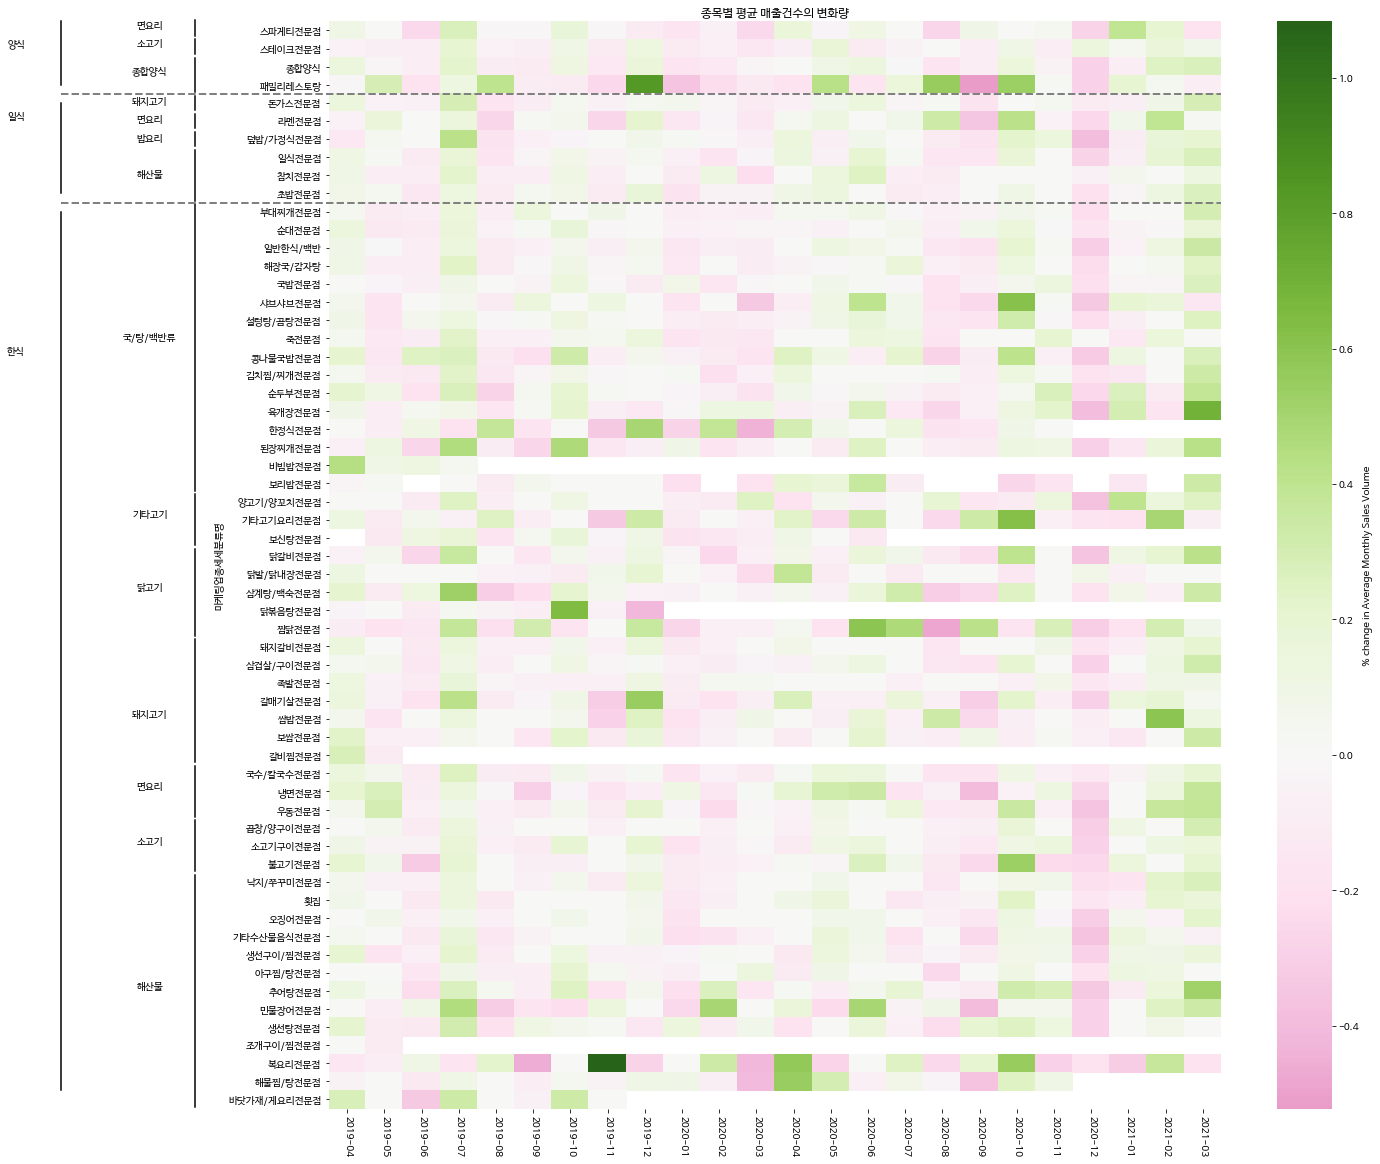

In [ ]:
d = data.groupby(['date','마케팅업종세세분류명'])['매출건수'].agg('median').groupby(['마케팅업종세세분류명']).pct_change()

df = pd.DataFrame(d).reset_index().pivot_table(index="마케팅업종세세분류명", columns="date", values="매출건수")

df= data[['마케팅업종중분류명','마케팅업종세분류명','마케팅업종세세분류명']].merge(df,on=['마케팅업종세세분류명']).drop_duplicates().sort_values(['마케팅업종중분류명','마케팅업종세분류명']).set_index('마케팅업종세세분류명')
df = df.drop(['마케팅업종중분류명','마케팅업종세분류명'], axis=1)


f, axes = plt.subplots(1, 1, figsize=(20,20))

ax = sns.heatmap(df, cbar_kws={'label': '% change in Average Monthly Sales Volume'},cmap="PiYG", center=0)

trans = ax.get_yaxis_transform()

# 마케팅업종중분류명
ax.annotate('양식', xy=(-0.35, 1), xycoords=trans, ha="center", va="top")
ax.plot([-0.3,-0.3],[0,3.5], color="k", transform=trans, clip_on=False)

ax.annotate('일식', xy=(-0.35, 5), xycoords=trans, ha="center", va="top")
ax.plot([-0.3,-0.3],[4.5,9.5], color="k", transform=trans, clip_on=False)

ax.annotate('한식', xy=(-0.35, 18), xycoords=trans, ha="center", va="top")
ax.plot([-0.3,-0.3],[10.5,59], color="k", transform=trans, clip_on=False)

# 마케팅업종세분류명
ax.annotate('면요리', xy=(-0.2, 0), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[-0.1,0.8], color="k", transform=trans, clip_on=False)

ax.annotate('소고기', xy=(-0.2, 1), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[1,1.8], color="k", transform=trans, clip_on=False)

ax.annotate('종합양식', xy=(-0.2, 2.5), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[2,3.9], color="k", transform=trans, clip_on=False)

ax.annotate('돼지고기', xy=(-0.2, 4.2), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[4.1,4.9], color="k", transform=trans, clip_on=False)

ax.annotate('면요리', xy=(-0.2, 5.2), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[5.1,5.9], color="k", transform=trans, clip_on=False)

ax.annotate('밥요리', xy=(-0.2, 6.2), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[6.1,6.9], color="k", transform=trans, clip_on=False)

ax.annotate('해산물', xy=(-0.2, 8.2), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[7.1,9.9], color="k", transform=trans, clip_on=False)

ax.annotate('국/탕/백반류', xy=(-0.2, 17.2), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[10.1,25.9], color="k", transform=trans, clip_on=False)

ax.annotate('기타고기', xy=(-0.2, 27), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[26.1,28.9], color="k", transform=trans, clip_on=False)

ax.annotate('닭고기', xy=(-0.2, 31), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[29.1,33.9], color="k", transform=trans, clip_on=False)

ax.annotate('돼지고기', xy=(-0.2, 38), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[34.1,40.9], color="k", transform=trans, clip_on=False)

ax.annotate('면요리', xy=(-0.2, 42), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[41.1,43.9], color="k", transform=trans, clip_on=False)

ax.annotate('소고기', xy=(-0.2, 45), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[44.1,46.9], color="k", transform=trans, clip_on=False)

ax.annotate('해산물', xy=(-0.2, 53), xycoords=trans, ha="center", va="top")
ax.plot([-0.15,-0.15],[47.1,59.9], color="k", transform=trans, clip_on=False)

ax.plot([-0.3,1],[4,4], linestyle='dashed', linewidth=2, color="gray", transform=trans,clip_on=False )
ax.plot([-0.3,1],[10,10], linestyle='dashed', linewidth=2, color="gray", transform=trans,clip_on=False)

ax.set_xticklabels(df.iloc[0].index.strftime('%Y-%m'))
plt.xticks(rotation=-90)
plt.title('종목별 평균 매출건수의 변화량')

plt.show()

# 월 매출건수 2000 이상인 지점들 

월 매출건수가 2000 이상인 점들이 대다수 였다. (n=401)
Each plot represents category-based cumulative sales by time. 

## 법정동리명
Cumulatively, the top restuarants in 역삼동 and 서교동 had well over 20000 sales per month before COVID. However, after January of 2020, the monthly sales volume dropped to 20000 and lower. The drop in absolute quantity of monthly sales volume for 연남동 and 서교동 음식점 was the most drastic out of all the other areas.

##  마케팅업종세세분류명
Cumulatively, 일반한식/백반, 일식점, and 종합음식 restuarants experienced the most sales volume per month. After January of 2020, the sales volume per month never recovered to pro

Based on the date of the first rapid spread of COVID=19 cases in Korea (January of 2020), the total sales valume of every category was negatively affected. 



<Figure size 432x288 with 0 Axes>

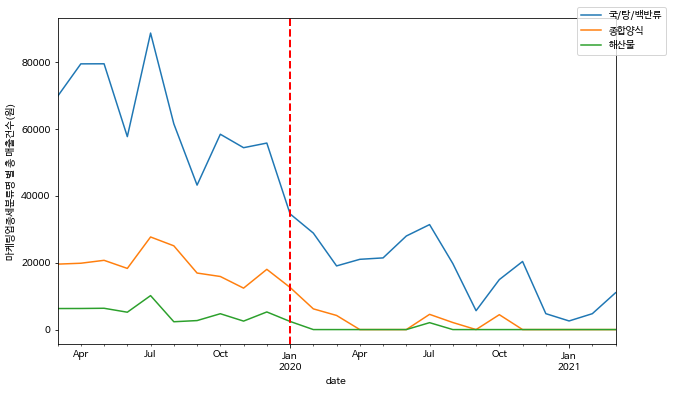

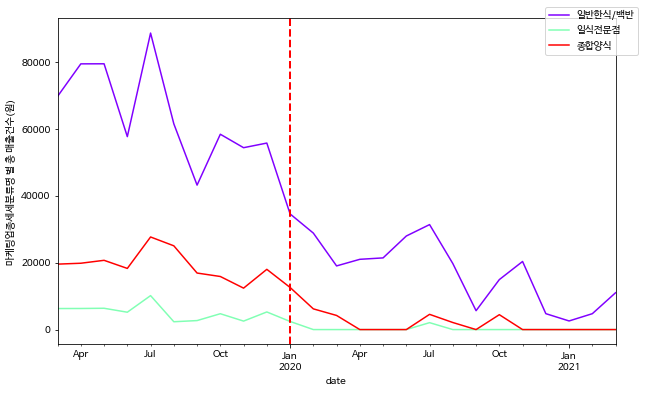

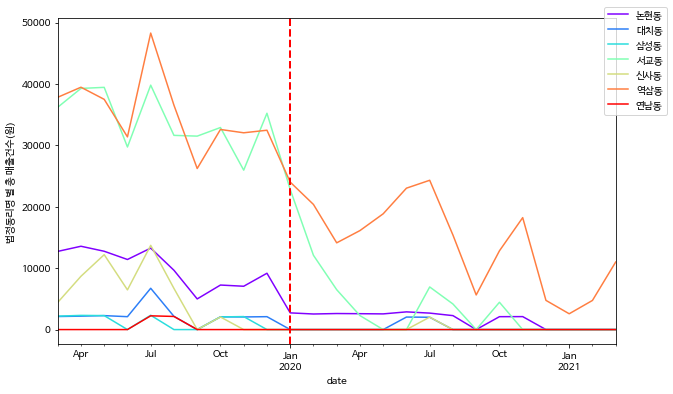

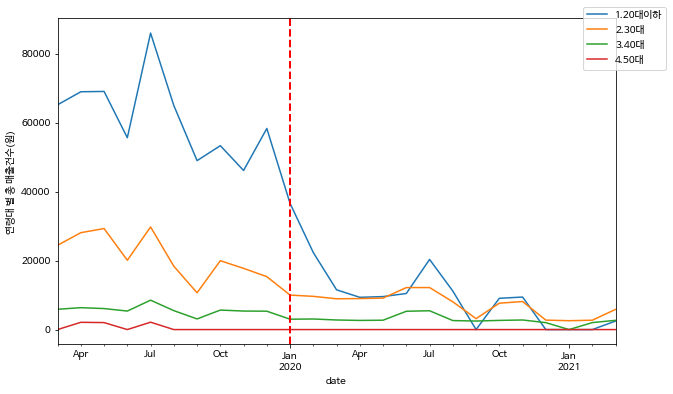

In [ ]:
from matplotlib import cm
colors = cm.get_cmap('rainbow')

fig = plt.figure()


data_detail_type = df_over2000.groupby(['date','마케팅업종세분류명'])['매출건수'].agg('sum')
ax1 = data_detail_type.unstack('마케팅업종세분류명', fill_value=0).plot(figsize=(10,6)).set_ylabel('마케팅업종세분류명 별 총 매출건수(원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05))


data_more_detail_type = df_over2000.groupby(['date','마케팅업종세세분류명'])['매출건수'].agg('sum')
ax2 = data_more_detail_type.unstack('마케팅업종세세분류명', fill_value=0).plot(figsize=(10,6), cmap=colors).set_ylabel('마케팅업종세세분류명 별 총 매출건수(원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.05, 1.05))


data_dong_type = df_over2000.groupby(['date','법정동리명'])['매출건수'].agg('sum')
ax3 = data_dong_type.unstack('법정동리명', fill_value=0).plot(figsize=(10,6), cmap=colors).set_ylabel('법정동리명 별 총 매출건수(원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05))


data_age_type = df_over2000.groupby(['date','연령대'])['매출건수'].agg('sum')
ax4 = data_age_type.unstack('연령대', fill_value=0).plot(figsize=(10,6)).set_ylabel('연령대 별 총 매출건수(원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05))

When stratifying stores where monthly sales volume was higher than 2000, the effect seems disproportionate across categories and levels. In terms of monthly mean 매출건수, 국/탕/백반류 and  일반 한식/백반 categories relatively maintained the same level of sales volume, albeit a slight decrease in mean 매출건수. 

역삼동 was the only area where the monthly mean 매출건수 was only slightly decreased after COVID. 논현동 mean 매출건수 fell drastically around august. 

<Figure size 432x288 with 0 Axes>

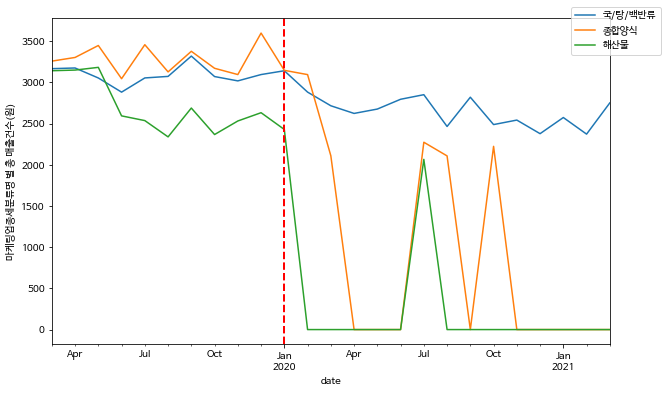

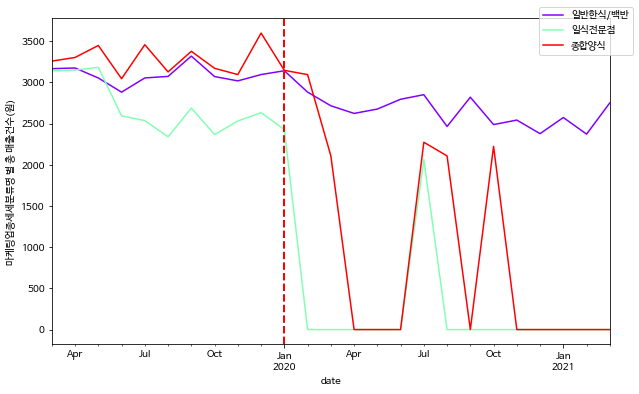

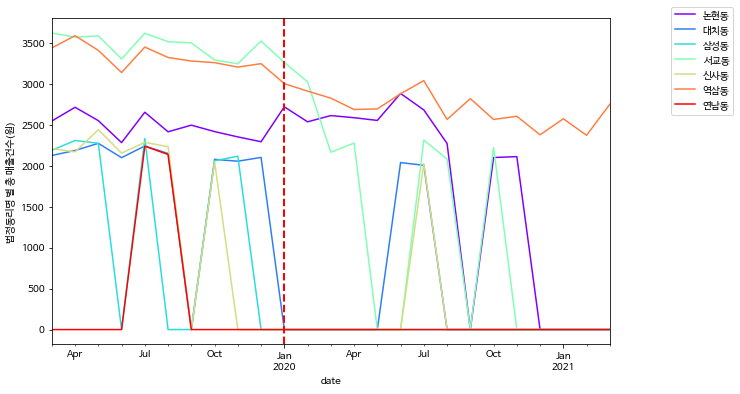

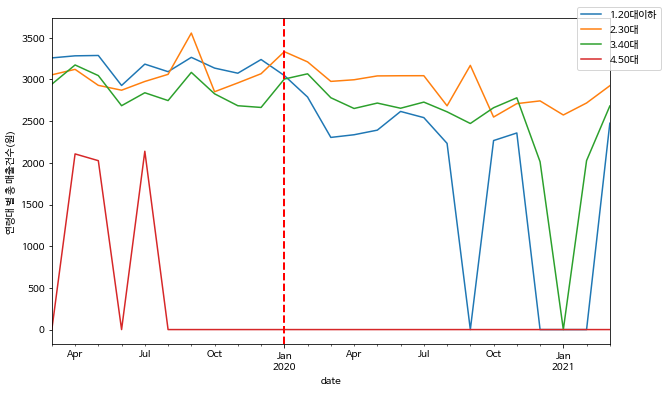

In [ ]:
from matplotlib import cm
colors = cm.get_cmap('rainbow')

fig = plt.figure()


data_detail_type = df_over2000.groupby(['date','마케팅업종세분류명'])['매출건수'].agg('mean')
ax1 = data_detail_type.unstack('마케팅업종세분류명', fill_value=0).plot(figsize=(10,6)).set_ylabel('마케팅업종세분류명 별 총 매출건수(원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05))


data_more_detail_type = df_over2000.groupby(['date','마케팅업종세세분류명'])['매출건수'].agg('mean')
ax2 = data_more_detail_type.unstack('마케팅업종세세분류명', fill_value=0).plot(figsize=(10,6), cmap=colors).set_ylabel('마케팅업종세세분류명 별 총 매출건수(원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.05, 1.05))


data_dong_type = df_over2000.groupby(['date','법정동리명'])['매출건수'].agg('mean')
ax3 = data_dong_type.unstack('법정동리명', fill_value=0).plot(figsize=(10,6), cmap=colors).set_ylabel('법정동리명 별 총 매출건수(원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05))


data_age_type = df_over2000.groupby(['date','연령대'])['매출건수'].agg('mean')
ax4 = data_age_type.unstack('연령대', fill_value=0).plot(figsize=(10,6)).set_ylabel('연령대 별 총 매출건수(원)')
plt.axvline(pd.to_datetime('2020-01-20'), color='r', linestyle='--', lw=2)
plt.legend(bbox_to_anchor=(1.1, 1.05))

# Map visualization

## 동를 기준으로 평균한 매출건수를 지도로 시각화

In [19]:
 def color_scale(data, column):
  """

  Input: dongmean data , column
  Output: color data with only that column in dongmean data, and the colormap (cmap)

  Define a color map in terms of each dong’s column mean for each year, then map the colors to a predefined color map. 

  To create the colormap, we calculate the maximum and minimum values over all the timeseries. 
  Then, convert datetime to U10 with pandas.DatetimeIndex() and astype()
  reference: https://jingwen-z.github.io/how-to-draw-a-variety-of-maps-with-folium-in-python/
  """
  data = data[['행정구역코드', 'date', column]].dropna()
 # data[column] = data[column].fillna(0)
  max_colour = max(data[column])
  min_colour = min(data[column])
  q3_colour = data[column].quantile(0.75)
  q2_colour = data[column].quantile(0.5)
  q1_colour = data[column].quantile(0.25)
  cmap = LinearColormap(
                      #colors=['gray', 'beige', 'yellow', 'orange', 'red', 'purple'], 
                      colors=['gray', 'yellow', 'red'], 
                      index=[0, min_colour,  max_colour],
                      vmin = min_colour, vmax = max_colour,
                      #scale_width = 800, scale_height=20
                      ).to_step(6)

  #cmap = linear.YlOrRd_09.scale(min_colour, max_colour) 
  # cmap = LinearColormap(['yellow','red'], vmin = min_colour, vmax = max_colour)
  
  data['colour'] = data[column].map(cmap)

  data['date_sec'] = pd.to_datetime(data['date']).astype(int) / 10**9
  data['date_sec'] = data['date_sec'].astype(int).astype(str)

  return data, cmap
  print(column, 'min_colour={} max_colour={}'.format(min_colour, max_colour))

In [20]:
# style_dictionary function required for time slider
def style_dictionary(data):

  """
  Input: dongmean_polygon
  Output: style_dict

  Note that dongmean has 2130 rows while dongmean_polygon 21302115. This is because there are some 법정동 in our data that is not in the geojson. 
  since the geopandas df (행정구역_gdf) was merged on dongmean_polygon, and the index must match for the style dictionary, use dongmean_polygon.

  Creating the style dictionary
  In the color map, Color is set, but opacity is not set here, so its just 0.7. If opacity needs to be set, 
  Do the same approach as color in the colorm_scale() function: calculate the max/min of the opacity column, so that we can map that column into a range [0,1]
  """
  구역_list = data['행정구역코드'].unique().tolist()
  구역_idx = range(len(구역_list))

  style_dict = {}
  for i in 구역_idx:
      구역 = 구역_list[i]
      result = data[data['행정구역코드'] == 구역]
      inner_dict = {}
      for _, r in result.iterrows():
          inner_dict[r['date_sec']] = {'color': r['colour'], 'opacity': 0.7}
      style_dict[str(i)] = inner_dict
  
  return style_dict

In [21]:
# function to make Time slider maps
def Time_slider_all(mapdata, data, column, metric): 

  #column=str(column)
  directory = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/KB/dong{0}/'.format(column)

  if not os.path.exists(directory):
    os.makedirs(directory)
  
  data, cmap = color_scale(data, column)
  style_dict = style_dictionary(data)

  map = folium.Map(location=[37.5502, 126.982], zoom_start=11, max_bounds=True)

  g = TimeSliderChoropleth(
      mapdata,
      styledict=style_dict, overlay = True
  ).add_to(map)

  map.add_child(cmap)

  if metric=='mean':
    cmap.caption = '평균 {0}'.format(column) + '____________'+  'Grey: No Data ; Yellow: Minimum'
  elif metric=='sum':
    cmap.caption = '총 {0}'.format(column) + '____________'+  'Grey: No Data ; Yellow: Minimum'
  map.add_child(folium.map.LayerControl())
  if metric=='mean':
    map.save(directory+'plot_dong_timeslider_mean{0}'.format(column))
  elif metric=='sum':
    map.save(directory+'plot_dong_timeslider_sum{0}'.format(column))
  

  display(map)

In [30]:
# Execute function
numcol_list = ['회원수',	'매출건수']

for column_name in numcol_list:
  Time_slider_all(행정구역_gdf, dongmean_polygon, column_name, 'mean')
  Time_slider_all(행정구역_gdf, dongsum_polygon, column_name, 'sum')

In [ ]:
times= sorted(c['date'].unique())

appended_data_dong={}
for i, date in enumerate(times):
  dongmean총지출=c[c['date']==date ].groupby('행정구역코드')['매출건수'].mean().reset_index()
  dongmean총지출['행정구역코드']=dongmean총지출['행정구역코드'].astype(str)
  appended_data_dong[date] = dongmean총지출


In [ ]:
geo_path = '/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/KB/HangJeongDong_ver20210401.geojson'
geo_str = json.load(open(geo_path ,encoding='utf-8'))

for year, yearlydata in appended_data_dong.items():
  map = folium.Map(location=[37.5502, 126.982], zoom_start=11,
                 )
  folium.Choropleth(geo_data=geo_str,
                data=yearlydata,
                columns=('행정구역코드', '매출건수'),
                fill_color='BuPu',
                fill_opacity=0.8,
                line_opacity=0.2,
                legend_name='동별 평균 매출건수',
                nan_fill_color = "Grey",
                threshold_scale=list(range(0, 176,25)), # 동병 평균들의 range
                key_on='feature.properties.adm_cd').add_to(map)
  folium.LayerControl().add_to(map)

  map.save('/content/drive/MyDrive/Colab Notebooks/Dacon/2021금용/KB/plot_dongmean매출건수_{0}.html'.format(year))